In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.cluster import KMeans

In [3]:
data = pd.read_csv("nominal_data_dengue_2010.csv")
data_by_date = pd.read_csv("data_by_date.csv")
gdf = gpd.GeoDataFrame(
    data_by_date, geometry=gpd.points_from_xy(data["x"], data["y"]), crs="EPSG:4326"
)
gdf

I_CUADRO  OBJECTID  Join_Count  TARGET_FID  ID_HILLO  ID_SON  ANYO  \
0     2010-01-30         1           1         217       231    6261     0   
1     2010-05-06         3           1         219       233    6425     0   
2     2010-05-09         2           1         218       232    6424     0   
3     2010-06-04         4           1         220       234    6497     0   
4     2010-07-04         6           2         222       236    6581     0   
...          ...       ...         ...         ...       ...     ...   ...   
2723  2010-12-28      2345           2        2562      2688   11089     0   
2724  2010-12-28      2348           1        2565      2691   11093     0   
2725  2010-12-31      2352           1        2569      2695   11113     0   
2726  2010-12-31      2353           1        2570      2696   11114     0   
2727  2010-12-31      2354           1        2571      2697   11115     0   

      FOLIO    SEXO  EDAD  ...          y Unnamed: 69  day week month  year  \
0        61  hombre    35  ...  29.129075         NaN   30    4     1  2010   
1       296  hombre    14  ...  29.131731         NaN    6   18     5  2010   
2       295   mujer    38  ...  29.131733         NaN    9   18     5  2010   
3       427   mujer    22  ...  29.124453         NaN    4   22     6  2010   
4       546  hombre    12  ...  29.138764         NaN    4   26     7  2010   
...     ...     ...   ...  ...        ...         ...  ...  ...   ...   ...   
2723   5648   mujer    66  ...  29.113262         NaN   28   52    12  2010   
2724   5652   mujer     7  ...  29.084639         NaN   28   52    12  2010   
2725   5676   mujer    41  ...  29.136562         NaN   31   52    12  2010   
2726   5677  hombre    38  ...  29.072824         NaN   31   52    12  2010   
2727   5678   mujer    14  ...  29.125468         NaN   31   52    12  2010   

     dayofyear  FD  FHD                     geometry  
0           30   1    0  POINT (-110.95896 29.12907)  
1          126   1    0  POINT (-110.96599 29.13173)  
2          129   1    0  POINT (-110.96599 29.13173)  
3          155   0    1  POINT (-110.97927 29.12445)  
4          185   1    0  POINT (-110.96328 29.13876)  
...        ...  ..  ...                          ...  
2723       362   1    0  POINT (-110.95999 29.11326)  
2724       362   0    1  POINT (-110.94337 29.08464)  
2725       365   1    0  POINT (-110.96156 29.13656)  
2726       365   1    0  POINT (-110.95555 29.07282)  
2727       365   0    1  POINT (-110.98951 29.12547)  

[2728 rows x 78 columns]

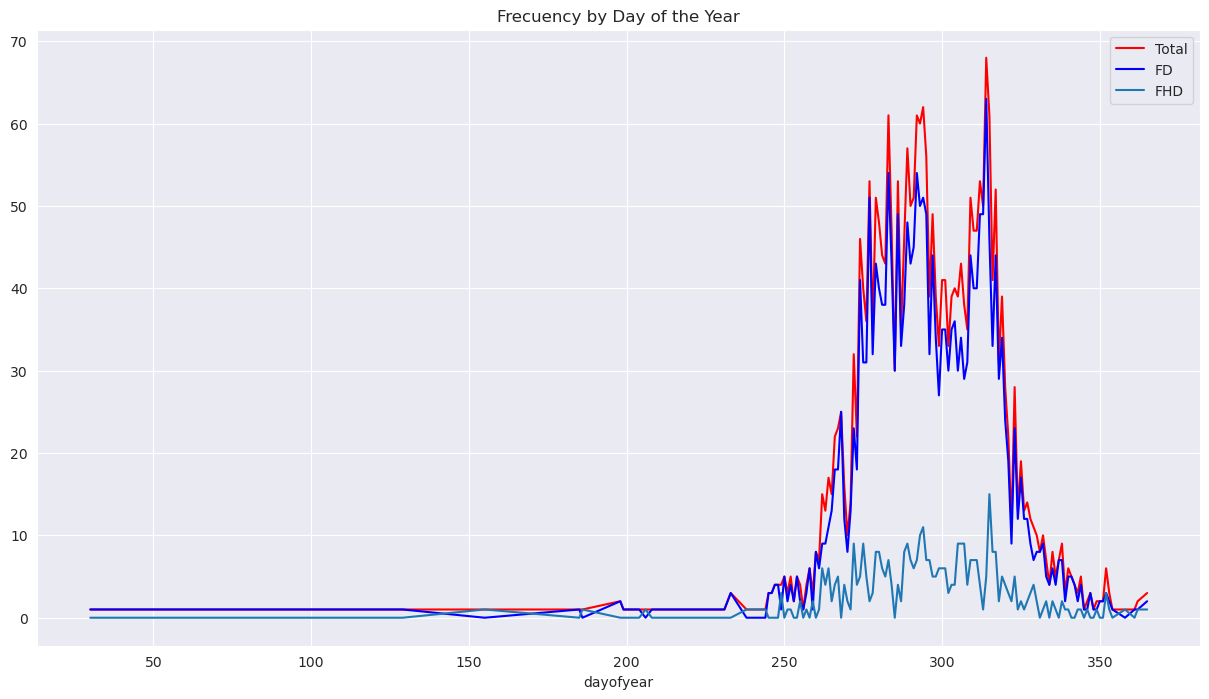

In [67]:
fig, ax = plt.subplots(figsize=(15,8))

data_by_date.groupby("dayofyear")["FD_FHD"].count().plot(ax=ax, color="red", label="Total")
data_by_date.groupby("dayofyear")["FD"].sum().plot(ax=ax, color="blue")
data_by_date.groupby("dayofyear")["FHD"].sum().plot(ax=ax)

plt.title("Frecuency by Day of the Year")
plt.legend()
plt.show()


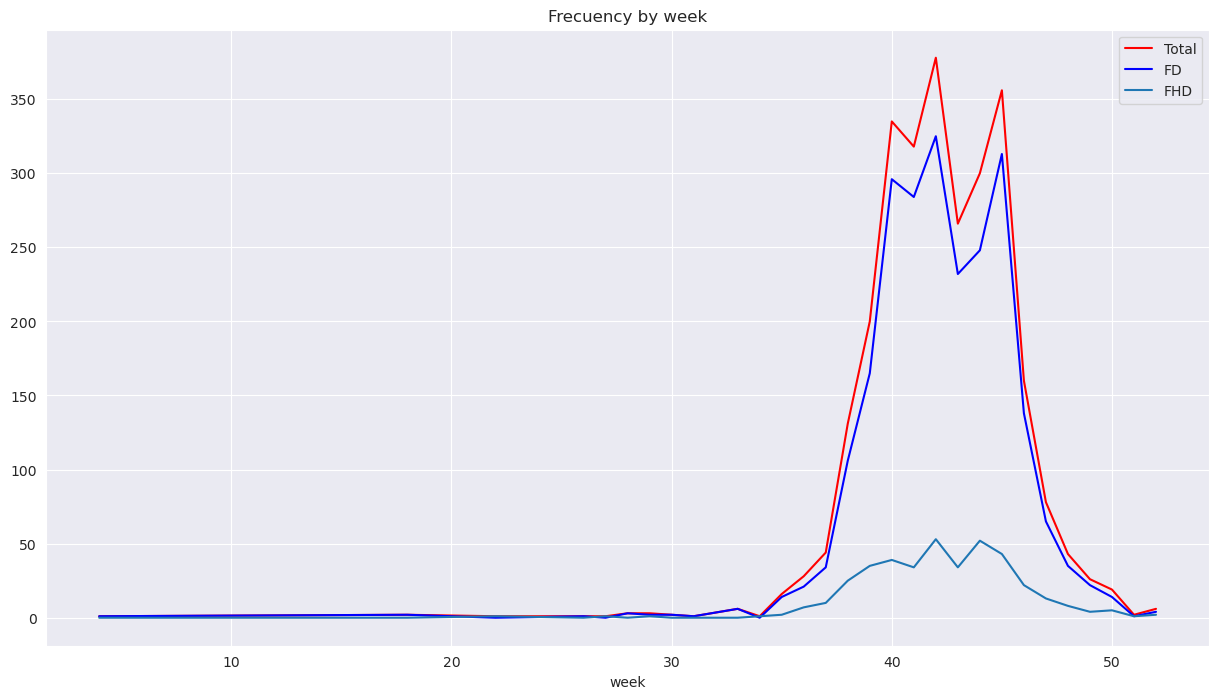

In [68]:
fig, ax = plt.subplots(figsize=(15,8))

data_by_date.groupby("week")["FD_FHD"].count().plot(ax=ax, color="red", label="Total")
data_by_date.groupby("week")["FD"].sum().plot(ax=ax, color="blue")
data_by_date.groupby("week")["FHD"].sum().plot(ax=ax)

plt.title("Frecuency by week")
plt.legend()
plt.show()

# Analysis by Day of Year

In [115]:
spike_data = data_by_date[data_by_date["I_CUADRO"] > "2010-08-28"]
spike_data = spike_data[spike_data["EDAD"] < 100]
spike_data.head()

I_CUADRO  OBJECTID  Join_Count  TARGET_FID  ID_HILLO  ID_SON  ANYO  \
22  2010-08-30        20           1         236       250    6904     0   
23  2010-09-01        25           1         241       255    6927     0   
24  2010-09-02        26           1         242       256    6928     0   
25  2010-09-02        27           1         243       257    6929     0   
26  2010-09-02        33           1         249       262    6944     0   

    FOLIO    SEXO  EDAD  ...           x          y  Unnamed: 69 day week  \
22    929   mujer     0  ... -111.015505  29.134184          NaN  30   35   
23    976  hombre    41  ... -110.964347  29.136228          NaN   1   35   
24    977   mujer    47  ... -110.966473  29.137403          NaN   2   35   
25    978  hombre     8  ... -110.964142  29.137217          NaN   2   35   
26    997  hombre    30  ... -110.967696  29.126753          NaN   2   35   

   month  year  dayofyear  FD  FHD  
22     8  2010        242   0    1  
23     9  2010        244   0    1  
24     9  2010        245   1    0  
25     9  2010        245   1    0  
26     9  2010        245   1    0  

[5 rows x 77 columns]

In [116]:
# Spike count by day

# Actual counts:
spike_count_by_day = pd.DataFrame(spike_data.groupby("dayofyear")["FD_FHD"].count())
spike_count_by_day["FD"] = spike_data.groupby("dayofyear")["FD"].sum()
spike_count_by_day["FHD"] = spike_data.groupby("dayofyear")["FHD"].sum()
# Cumulative total:
spike_count_by_day["FD_FHD_cumsum"] = spike_count_by_day["FD_FHD"].cumsum()
spike_count_by_day["FD_cumsum"] = spike_count_by_day["FD"].cumsum()
spike_count_by_day["FHD_cumsum"] = spike_count_by_day["FHD"].cumsum()
# Rolling mean:
spike_count_by_day["FD_FHD_mean"] = spike_count_by_day["FD_FHD"].rolling(3).mean()
spike_count_by_day["FD_mean"] = spike_count_by_day["FD"].rolling(3).mean()
spike_count_by_day["FHD_mean"] = spike_count_by_day["FHD"].rolling(3).mean()

spike_count_by_day.tail()

FD_FHD  FD  FHD  FD_FHD_cumsum  FD_cumsum  FHD_cumsum  FD_FHD_mean  \
dayofyear                                                                       
354             1   1    0           2698       2312         386     3.333333   
358             1   0    1           2699       2312         387     1.666667   
361             1   1    0           2700       2313         387     1.000000   
362             2   1    1           2702       2314         388     1.333333   
365             3   2    1           2705       2316         389     2.000000   

            FD_mean  FHD_mean  
dayofyear                      
354        2.000000  1.333333  
358        1.000000  0.666667  
361        0.666667  0.333333  
362        0.666667  0.666667  
365        1.333333  0.666667

In [117]:
division_1_day = 283 # 11/Oct./2010
division_2_day = 314 # 9/Nov./2010

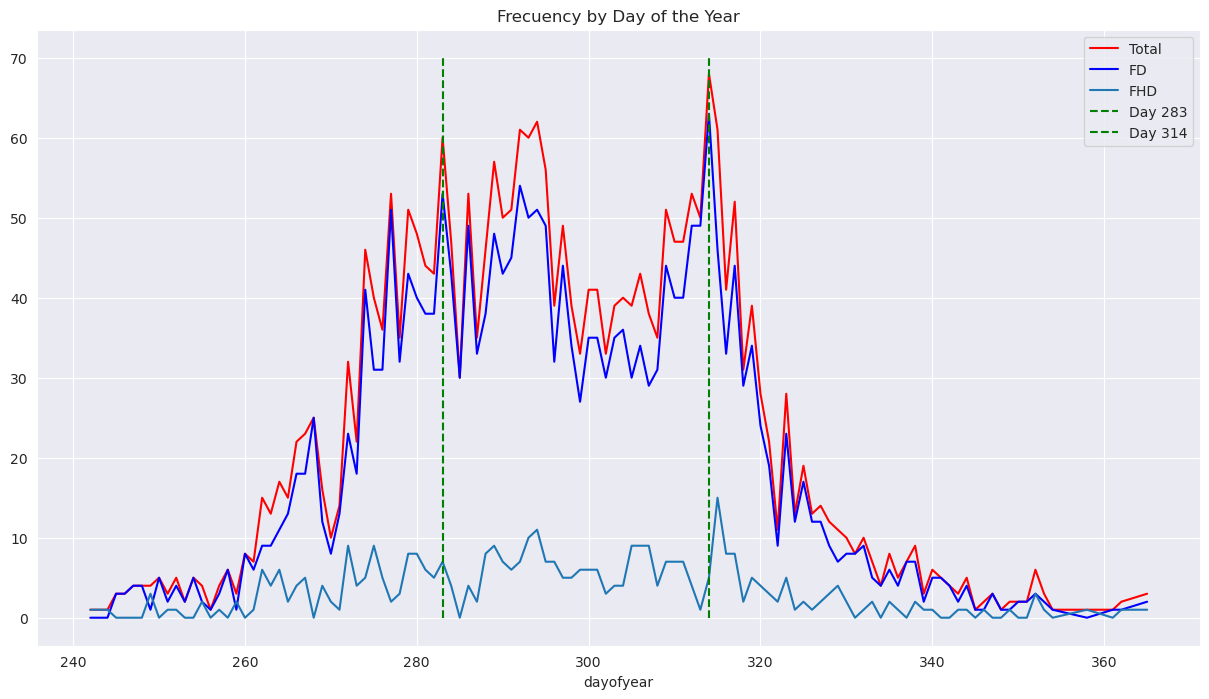

In [118]:
fig, ax = plt.subplots(figsize=(15,8))

spike_count_by_day["FD_FHD"].plot(ax=ax, color="red", label="Total")
spike_count_by_day["FD"].plot(ax=ax, color="blue")
spike_count_by_day["FHD"].plot(ax=ax)
plt.vlines(division_1_day, 0, 70, colors="green", linestyles='dashed', label=f"Day {division_1_day}")
plt.vlines(division_2_day, 0, 70, colors="green", linestyles='dashed', label=f"Day {division_2_day}")

plt.title("Frecuency by Day of the Year")
plt.legend()
plt.show()


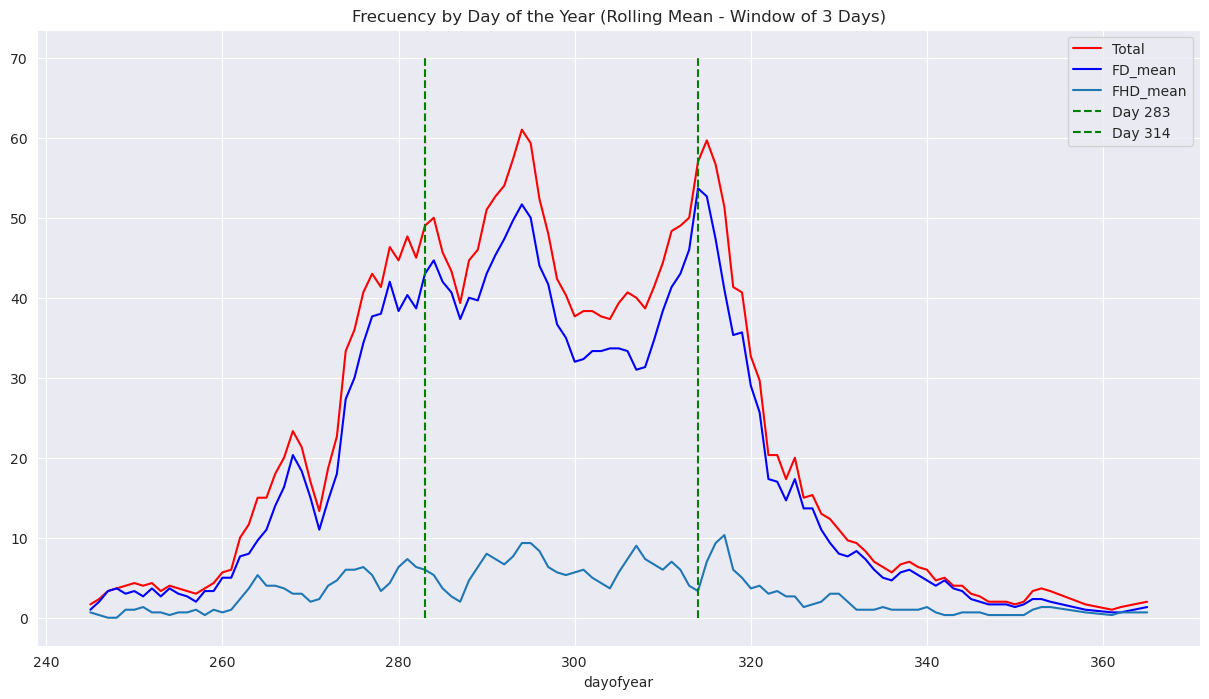

In [119]:
fig, ax = plt.subplots(figsize=(15,8))

spike_count_by_day["FD_FHD_mean"].plot(ax=ax, color="red", label="Total")
spike_count_by_day["FD_mean"].plot(ax=ax, color="blue")
spike_count_by_day["FHD_mean"].plot(ax=ax)
plt.vlines(division_1_day, 0, 70, colors="green", linestyles='dashed', label=f"Day {division_1_day}")
plt.vlines(division_2_day, 0, 70, colors="green", linestyles='dashed', label=f"Day {division_2_day}")

plt.title("Frecuency by Day of the Year (Rolling Mean - Window of 3 Days)")
plt.legend()
plt.show()


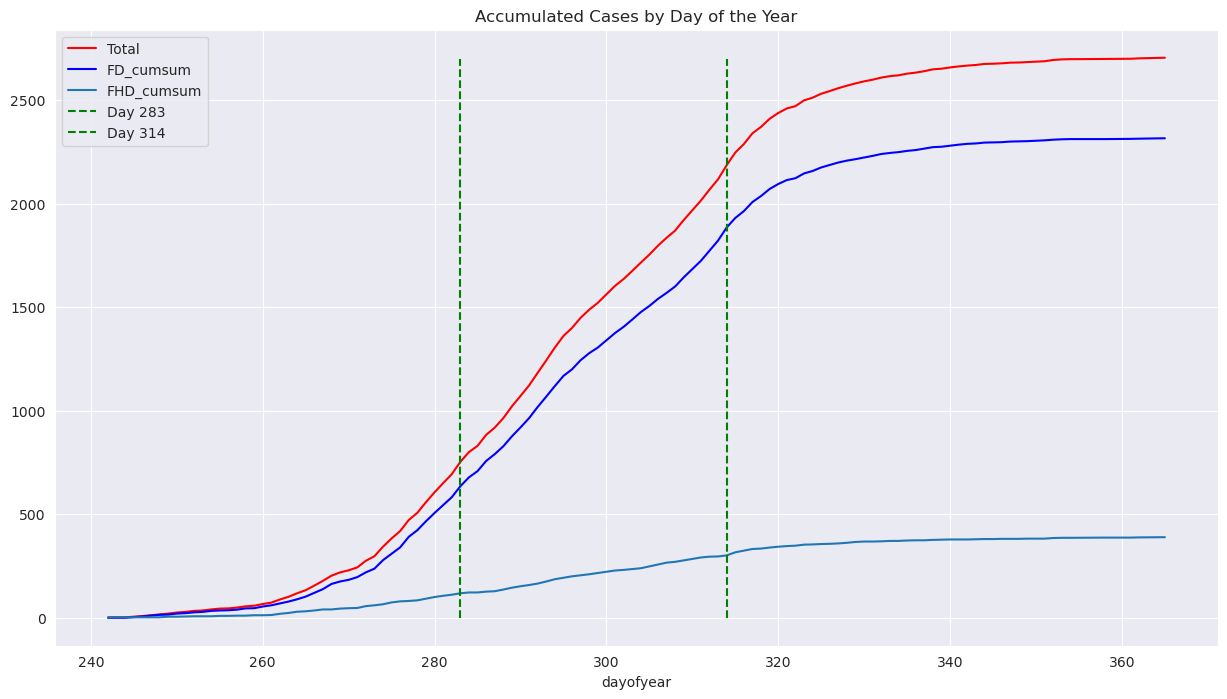

In [120]:
fig, ax = plt.subplots(figsize=(15,8))

spike_count_by_day["FD_FHD_cumsum"].plot(ax=ax, color="red", label="Total")
spike_count_by_day["FD_cumsum"].plot(ax=ax, color="blue")
spike_count_by_day["FHD_cumsum"].plot(ax=ax)
plt.vlines(division_1_day, 0, 2700, colors="green", linestyles='dashed', label=f"Day {division_1_day}")
plt.vlines(division_2_day, 0, 2700, colors="green", linestyles='dashed', label=f"Day {division_2_day}")

plt.title("Accumulated Cases by Day of the Year")
plt.legend()
plt.show()


In [121]:
data_sec_1 = spike_data[spike_data["I_CUADRO"] < "2010-10-11"]
data_sec_2 = spike_data[spike_data["I_CUADRO"] > "2010-10-11"][spike_data["I_CUADRO"] < "2010-11-09"]
data_sec_3 = spike_data[spike_data["I_CUADRO"] > "2010-11-09"]

/tmp/ipykernel_235355/3645623046.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_sec_2 = spike_data[spike_data["I_CUADRO"] > "2010-10-11"][spike_data["I_CUADRO"] < "2010-11-09"]


In [122]:
# Spike count by day

# Actual counts:
data_sec_1_count = pd.DataFrame(data_sec_1.groupby("dayofyear")["FD_FHD"].count())
data_sec_1_count["FD"] = data_sec_1.groupby("dayofyear")["FD"].sum()
data_sec_1_count["FHD"] = data_sec_1.groupby("dayofyear")["FHD"].sum()
# Cumulative total:
data_sec_1_count["FD_FHD_cumsum"] = data_sec_1_count["FD_FHD"].cumsum()
data_sec_1_count["FD_cumsum"] = data_sec_1_count["FD"].cumsum()
data_sec_1_count["FHD_cumsum"] = data_sec_1_count["FHD"].cumsum()
# Rolling mean:
data_sec_1_count["FD_FHD_mean"] = data_sec_1_count["FD_FHD"].rolling(3).mean()
data_sec_1_count["FD_mean"] = data_sec_1_count["FD"].rolling(3).mean()
data_sec_1_count["FHD_mean"] = data_sec_1_count["FHD"].rolling(3).mean()

FD_FHD_cumsum_sec_1_total = data_sec_1_count["FD_FHD"].sum()
FD_cumsum_sec_1_total = data_sec_1_count["FD"].sum()
FHD_cumsum_sec_1_total = data_sec_1_count["FHD"].sum()

data_sec_1_count.tail()

FD_FHD  FD  FHD  FD_FHD_cumsum  FD_cumsum  FHD_cumsum  FD_FHD_mean  \
dayofyear                                                                       
279            51  43    8            558        466          92    46.333333   
280            48  40    8            606        506         100    44.666667   
281            44  38    6            650        544         106    47.666667   
282            43  38    5            693        582         111    45.000000   
283            60  53    7            753        635         118    49.000000   

             FD_mean  FHD_mean  
dayofyear                       
279        42.000000  4.333333  
280        38.333333  6.333333  
281        40.333333  7.333333  
282        38.666667  6.333333  
283        43.000000  6.000000

In [123]:
# Spike count by day

# Actual counts:
data_sec_2_count = pd.DataFrame(data_sec_2.groupby("dayofyear")["FD_FHD"].count())
data_sec_2_count["FD"] = data_sec_2.groupby("dayofyear")["FD"].sum()
data_sec_2_count["FHD"] = data_sec_2.groupby("dayofyear")["FHD"].sum()
# Cumulative total:
data_sec_2_count["FD_FHD_cumsum"] = data_sec_2_count["FD_FHD"].cumsum()
data_sec_2_count["FD_FHD_cumsum"] = data_sec_2_count["FD_FHD_cumsum"] + FD_FHD_cumsum_sec_1_total
data_sec_2_count["FD_cumsum"] = data_sec_2_count["FD"].cumsum()
data_sec_2_count["FD_cumsum"] = data_sec_2_count["FD_cumsum"] + FD_cumsum_sec_1_total
data_sec_2_count["FHD_cumsum"] = data_sec_2_count["FHD"].cumsum()
data_sec_2_count["FHD_cumsum"] = data_sec_2_count["FHD_cumsum"] + FHD_cumsum_sec_1_total
# Rolling mean:
data_sec_2_count["FD_FHD_mean"] = data_sec_2_count["FD_FHD"].rolling(3).mean()
data_sec_2_count["FD_mean"] = data_sec_2_count["FD"].rolling(3).mean()
data_sec_2_count["FHD_mean"] = data_sec_2_count["FHD"].rolling(3).mean()

FD_FHD_cumsum_sec_2_total = data_sec_2_count["FD_FHD"].sum()
FD_cumsum_sec_2_total = data_sec_2_count["FD"].sum()
FHD_cumsum_sec_2_total = data_sec_2_count["FHD"].sum()

data_sec_2_count.tail()

FD_FHD  FD  FHD  FD_FHD_cumsum  FD_cumsum  FHD_cumsum  FD_FHD_mean  \
dayofyear                                                                       
308            35  31    4           1823       1557         266    38.666667   
309            51  44    7           1874       1601         273    41.333333   
310            47  40    7           1921       1641         280    44.333333   
311            47  40    7           1968       1681         287    48.333333   
312            53  49    4           2021       1730         291    49.000000   

             FD_mean  FHD_mean  
dayofyear                       
308        31.333333  7.333333  
309        34.666667  6.666667  
310        38.333333  6.000000  
311        41.333333  7.000000  
312        43.000000  6.000000

In [124]:
# Spike count by day

# Actual counts:
data_sec_3_count = pd.DataFrame(data_sec_3.groupby("dayofyear")["FD_FHD"].count())
data_sec_3_count["FD"] = data_sec_3.groupby("dayofyear")["FD"].sum()
data_sec_3_count["FHD"] = data_sec_3.groupby("dayofyear")["FHD"].sum()
# Cumulative total:
data_sec_3_count["FD_FHD_cumsum"] = data_sec_3_count["FD_FHD"].cumsum()
data_sec_3_count["FD_FHD_cumsum"] = data_sec_3_count["FD_FHD_cumsum"] + FD_FHD_cumsum_sec_2_total
data_sec_3_count["FD_cumsum"] = data_sec_3_count["FD"].cumsum()
data_sec_3_count["FD_cumsum"] = data_sec_3_count["FD_cumsum"] + FD_cumsum_sec_2_total
data_sec_3_count["FHD_cumsum"] = data_sec_3_count["FHD"].cumsum()
data_sec_3_count["FHD_cumsum"] = data_sec_3_count["FHD_cumsum"] + FHD_cumsum_sec_2_total
# Rolling mean:
data_sec_3_count["FD_FHD_mean"] = data_sec_3_count["FD_FHD"].rolling(3).mean()
data_sec_3_count["FD_mean"] = data_sec_3_count["FD"].rolling(3).mean()
data_sec_3_count["FHD_mean"] = data_sec_3_count["FHD"].rolling(3).mean()

data_sec_3_count.tail()

FD_FHD  FD  FHD  FD_FHD_cumsum  FD_cumsum  FHD_cumsum  FD_FHD_mean  \
dayofyear                                                                       
354             1   1    0           1848       1585         263     3.333333   
358             1   0    1           1849       1585         264     1.666667   
361             1   1    0           1850       1586         264     1.000000   
362             2   1    1           1852       1587         265     1.333333   
365             3   2    1           1855       1589         266     2.000000   

            FD_mean  FHD_mean  
dayofyear                      
354        2.000000  1.333333  
358        1.000000  0.666667  
361        0.666667  0.333333  
362        0.666667  0.666667  
365        1.333333  0.666667

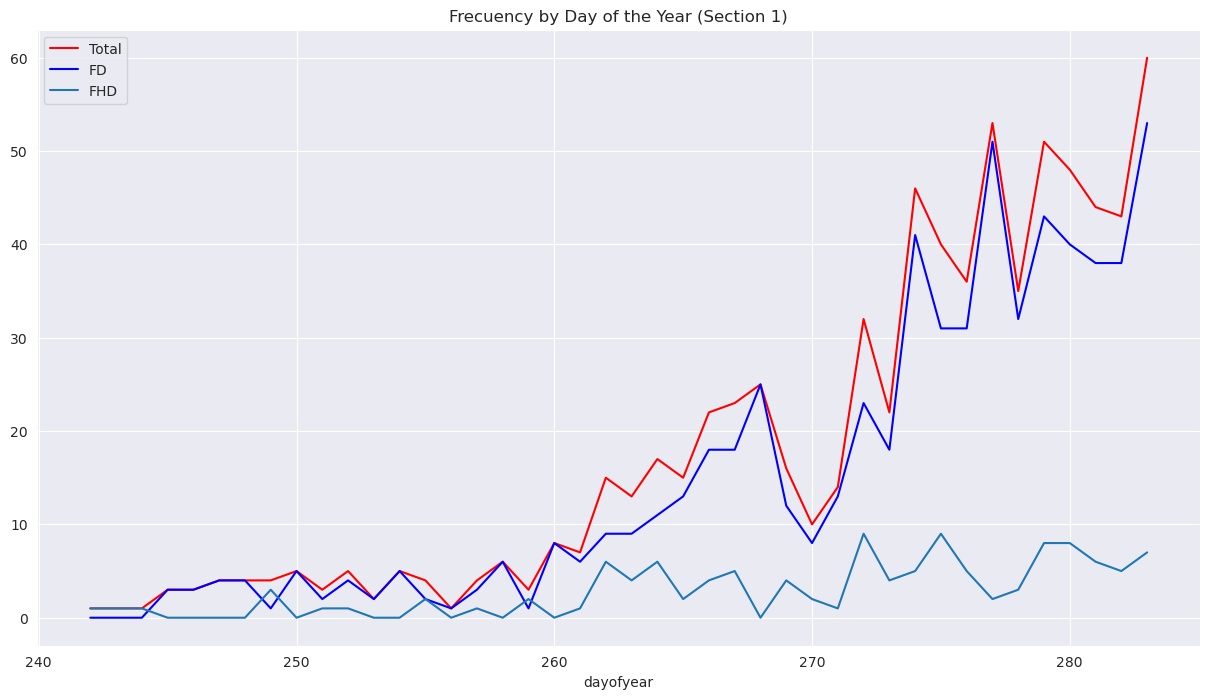

In [125]:
fig, ax = plt.subplots(figsize=(15,8))

data_sec_1_count["FD_FHD"].plot(ax=ax, color="red", label="Total")
data_sec_1_count["FD"].plot(ax=ax, color="blue")
data_sec_1_count["FHD"].plot(ax=ax)

plt.title("Frecuency by Day of the Year (Section 1)")
plt.legend()
plt.show()


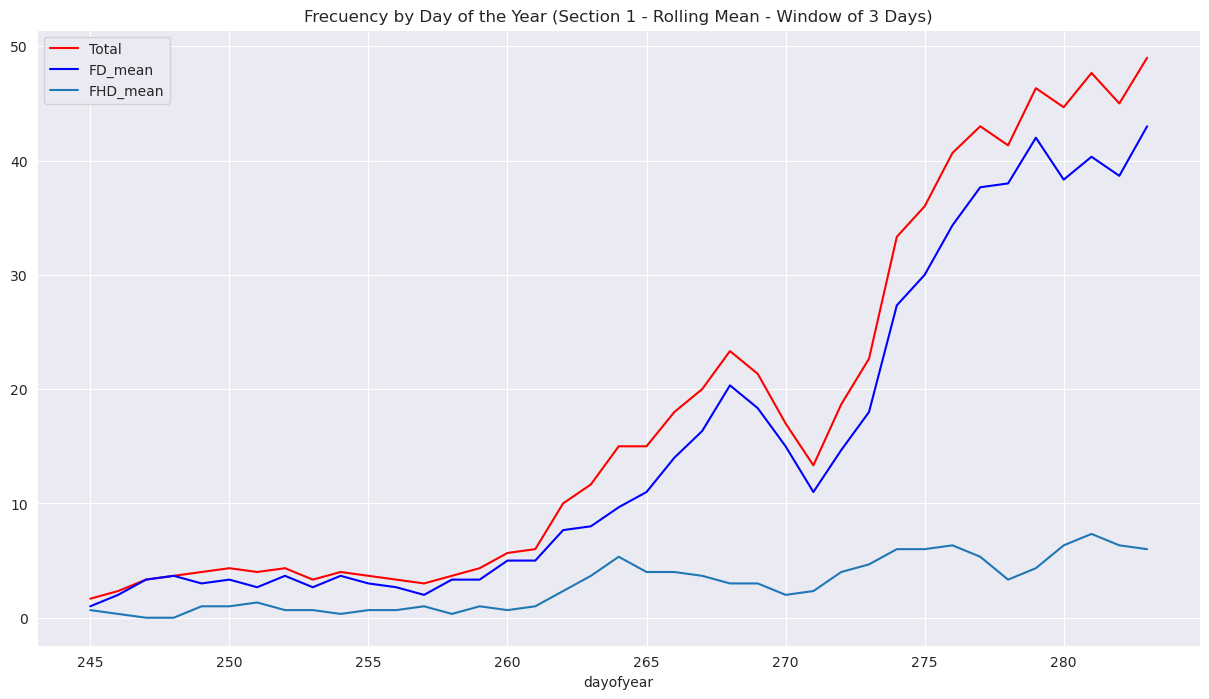

In [126]:
fig, ax = plt.subplots(figsize=(15,8))

data_sec_1_count["FD_FHD_mean"].plot(ax=ax, color="red", label="Total")
data_sec_1_count["FD_mean"].plot(ax=ax, color="blue")
data_sec_1_count["FHD_mean"].plot(ax=ax)

plt.title("Frecuency by Day of the Year (Section 1 - Rolling Mean - Window of 3 Days)")
plt.legend()
plt.show()


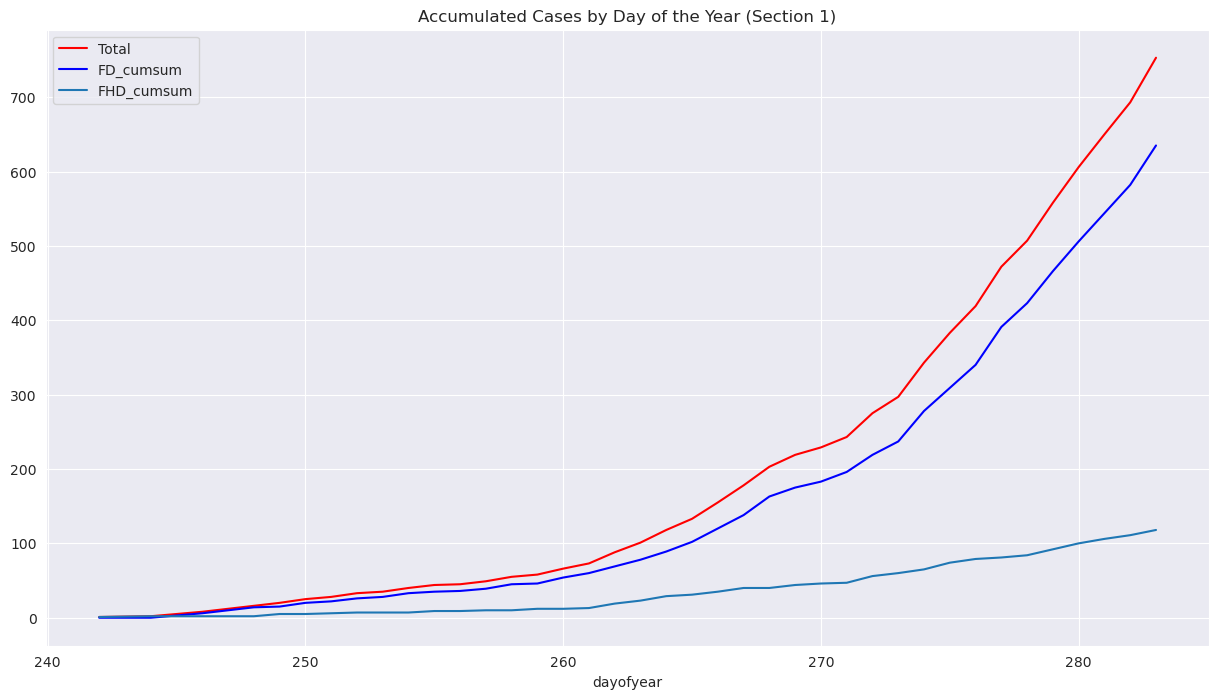

In [127]:
fig, ax = plt.subplots(figsize=(15,8))

data_sec_1_count["FD_FHD_cumsum"].plot(ax=ax, color="red", label="Total")
data_sec_1_count["FD_cumsum"].plot(ax=ax, color="blue")
data_sec_1_count["FHD_cumsum"].plot(ax=ax)
plt.title("Accumulated Cases by Day of the Year (Section 1)")
plt.legend()
plt.show()


In [128]:
kmeans_sec_1_df = data_sec_1[["x", "y", "SEXO", "EDAD", "GRADO_MA_1", "DENSI_POB", "week", "FD_FHD"]]
kmeans_sec_1_df.set_index(np.arange(len(kmeans_sec_1_df)), inplace=True)

sexo_df = pd.get_dummies(kmeans_sec_1_df["SEXO"], dtype="int", drop_first=True)
kmeans_sec_1_df = pd.concat([kmeans_sec_1_df, sexo_df], axis=1)
kmeans_sec_1_df.drop("SEXO", axis=1, inplace=True)

fd_fhd_df = pd.get_dummies(kmeans_sec_1_df["FD_FHD"], dtype="int", drop_first=True)
kmeans_sec_1_df = pd.concat([kmeans_sec_1_df, fd_fhd_df], axis=1)
kmeans_sec_1_df.drop("FD_FHD", axis=1, inplace=True)

kmeans_sec_1_df.columns = ["x", "y", "edad", "grad_marg", "densi_pob", "semana", "sexo", "FHD"]

kmeans_sec_1_df.head()

x          y  edad  grad_marg   densi_pob  semana  sexo  FHD
0 -111.015505  29.134184     0          3   77.445107      35     1    1
1 -110.964347  29.136228    41          3  122.000382      35     0    1
2 -110.966473  29.137403    47          3  122.000382      35     1    0
3 -110.964142  29.137217     8          3  122.000382      35     0    0
4 -110.967696  29.126753    30          2   83.995697      35     0    0

In [130]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
standard_scaled_df = pd.DataFrame(standard_scaler.fit_transform(kmeans_sec_1_df.drop(["sexo", "grad_marg", "semana", "FHD"], axis=1)))
min_max_scaled_df = pd.DataFrame(min_max_scaler.fit_transform(kmeans_sec_1_df[["grad_marg", "semana"]]))
standard_scaled_df.columns = ["x", "y", "edad", "densi_pob"]
min_max_scaled_df.columns = ["grad_marg", "semana"]

In [131]:
kmeans_sec_1_df = pd.concat([standard_scaled_df, min_max_scaled_df, kmeans_sec_1_df["sexo"]], axis=1)
kmeans_sec_1_df.head()

x         y      edad  densi_pob  grad_marg  semana  sexo
0 -2.122015  0.464568 -1.741001  -0.409143       0.50     0.0     1
1  0.606867  0.563168  0.582215   1.374643       0.50     0.0     0
2  0.493456  0.619844  0.922198   1.374643       0.50     0.0     1
3  0.617770  0.610859 -1.287690   1.374643       0.50     0.0     0
4  0.428213  0.106083 -0.041087  -0.146888       0.25     0.0     0

In [132]:
kmeans_sec_1_df.isna().sum()

x            0
y            0
edad         0
densi_pob    0
grad_marg    0
semana       0
sexo         0
dtype: int64

In [133]:
kmeans_sec_1 = KMeans(n_clusters=4).fit(kmeans_sec_1_df)
kmeans_sec_1.labels_

array([1, 3, 3, 0, 0, 0, 0, 1, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 1, 3, 3, 0, 3, 3, 0, 2, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 3, 1, 0, 1, 0, 0, 3, 1, 0, 3, 1, 0,
       0, 0, 3, 3, 0, 0, 3, 0, 0, 0, 1, 0, 3, 0, 1, 0, 1, 1, 0, 0, 3, 3,
       0, 0, 3, 3, 1, 0, 1, 1, 0, 2, 0, 3, 0, 0, 1, 0, 0, 1, 0, 1, 0, 2,
       0, 1, 0, 1, 3, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 1,
       0, 0, 3, 0, 2, 1, 3, 2, 0, 0, 0, 0, 0, 0, 2, 3, 1, 0, 0, 3, 0, 0,
       3, 0, 0, 1, 1, 0, 0, 3, 0, 3, 1, 3, 0, 0, 3, 1, 1, 0, 3, 1, 2, 3,
       3, 0, 0, 0, 3, 1, 3, 3, 3, 0, 0, 0, 0, 3, 0, 3, 2, 3, 0, 1, 0, 1,
       0, 3, 1, 1, 3, 3, 3, 3, 2, 0, 3, 3, 1, 1, 0, 3, 0, 3, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 3, 0, 3, 3, 0, 0, 1, 0, 3, 3, 0, 3, 0,
       3, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 3, 3, 1, 3, 1, 1, 0, 1, 2, 0, 1,
       0, 1, 0, 2, 1, 1, 1, 0, 0, 3, 0, 3, 0, 0, 3, 0, 2, 2, 3, 3, 3, 0,
       1, 0, 0, 3, 0, 3, 0, 3, 1, 0, 3, 2, 0, 3, 3,

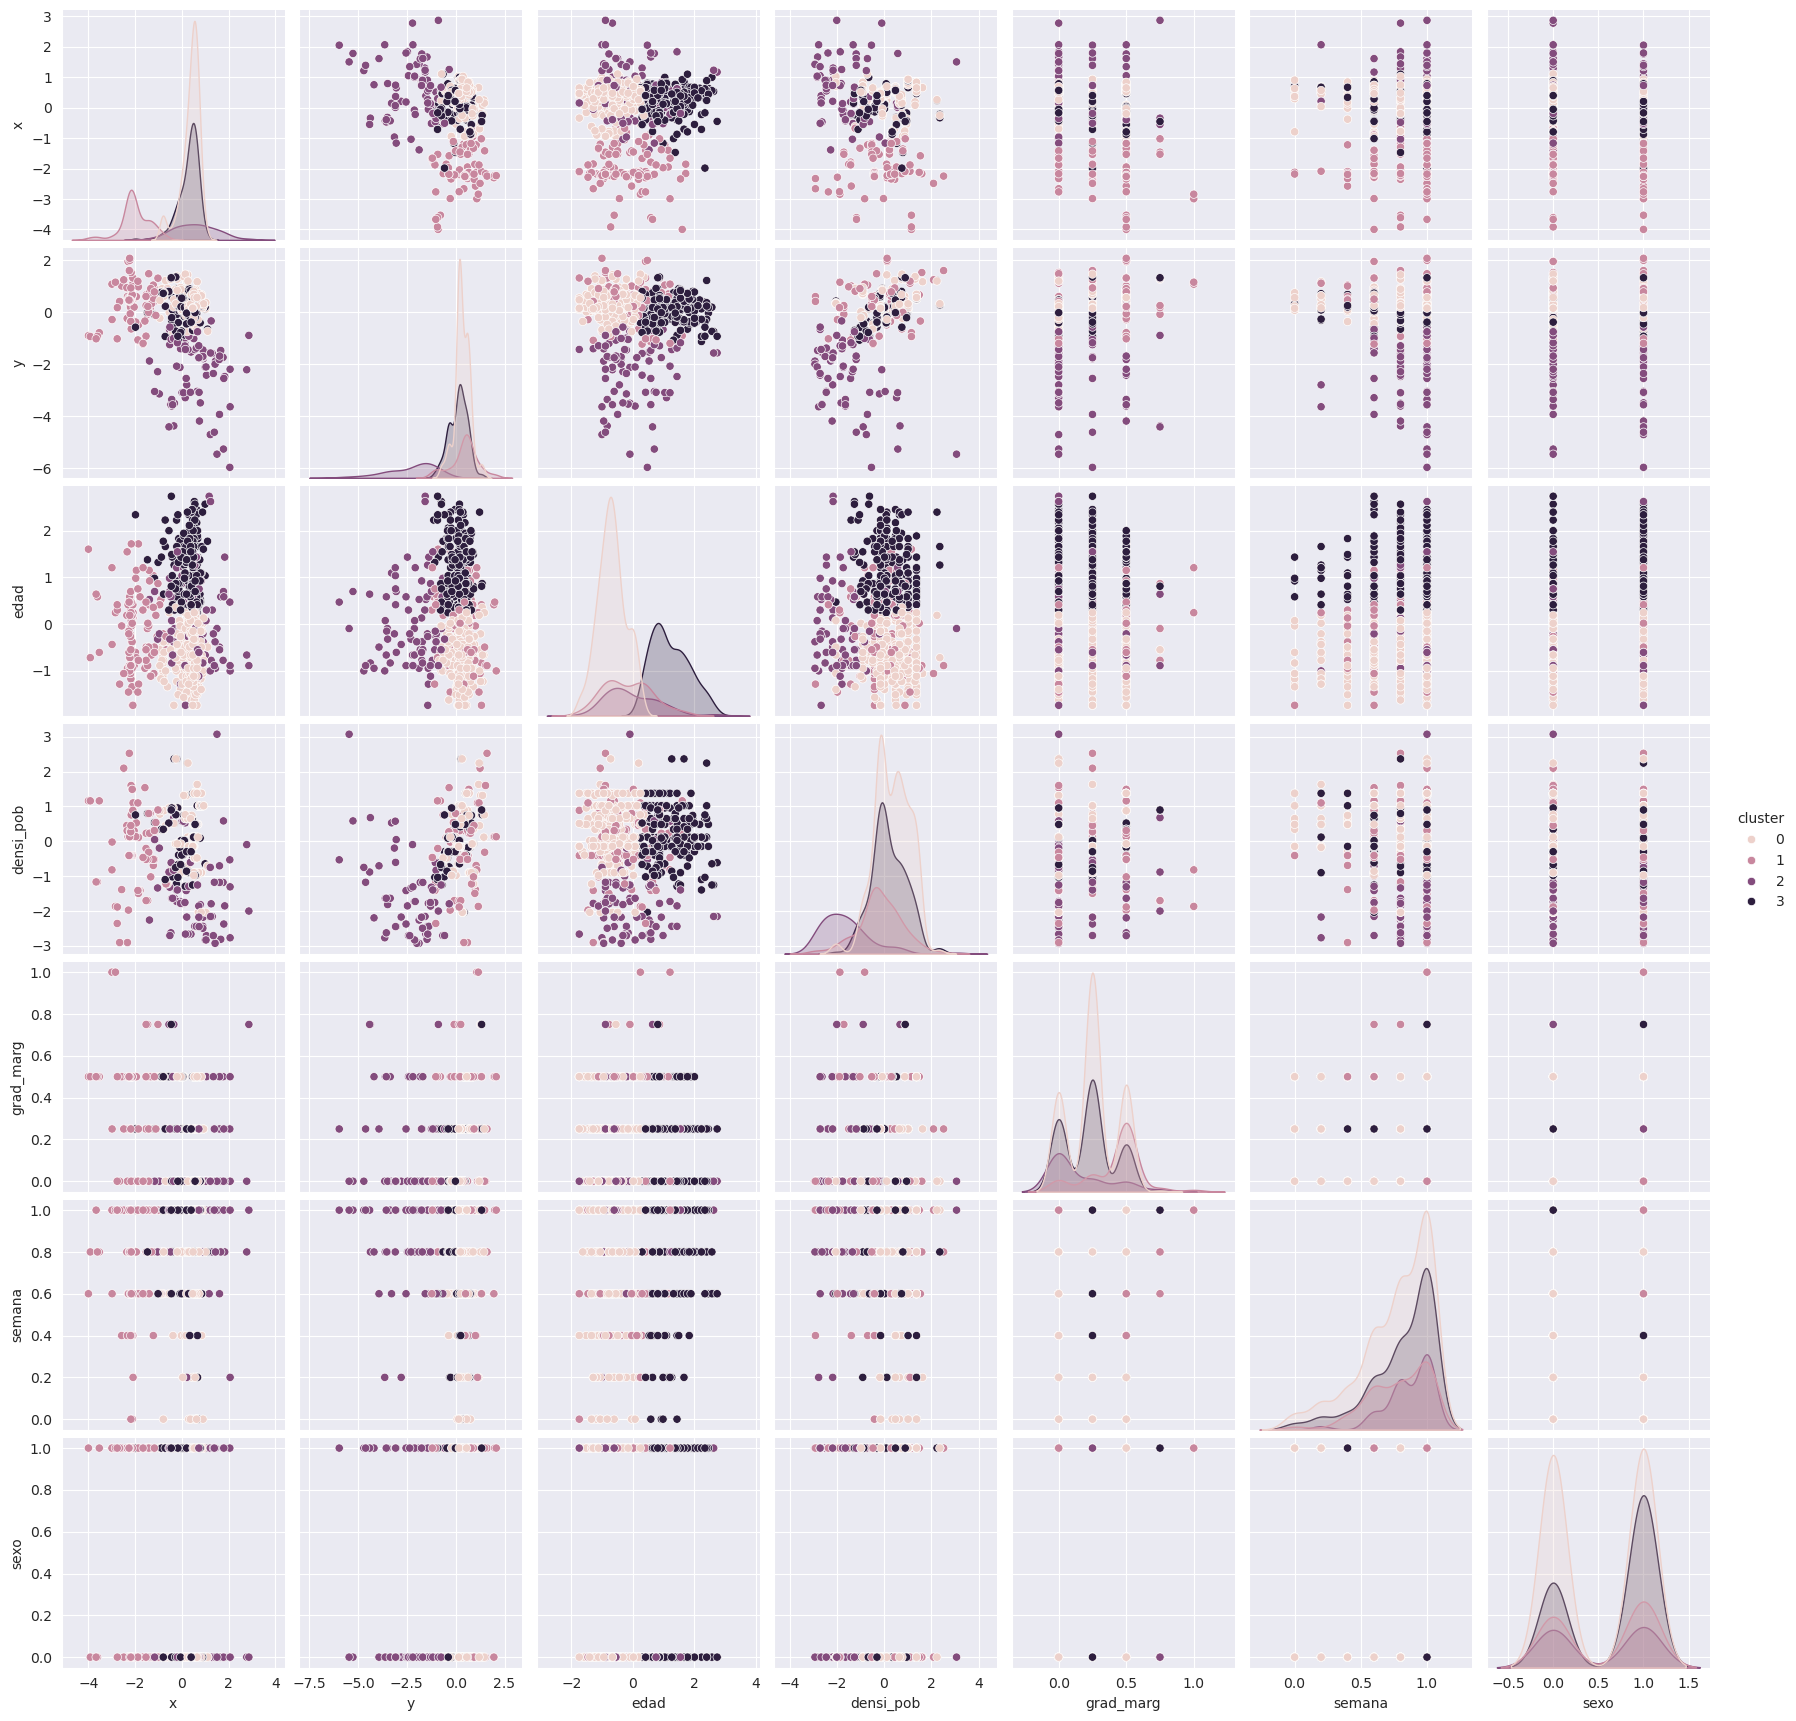

In [134]:
kmeans_sec_1_df["cluster"] = kmeans_sec_1.labels_
sns.pairplot(kmeans_sec_1_df, hue="cluster")

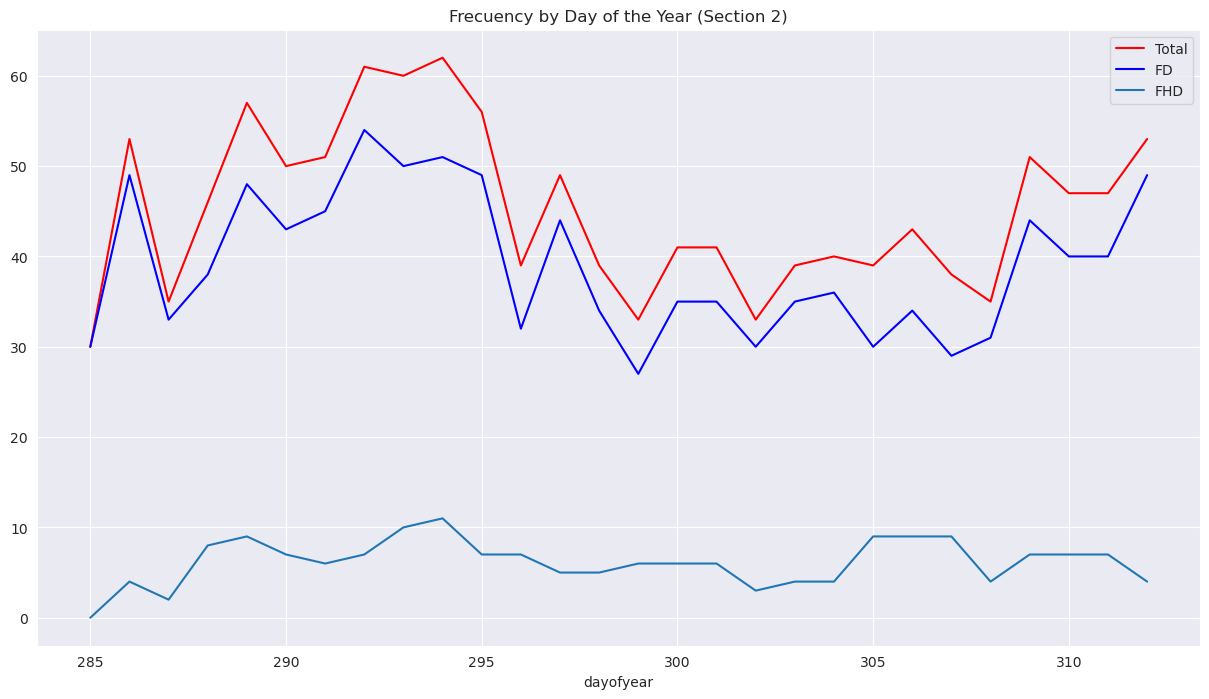

In [135]:
fig, ax = plt.subplots(figsize=(15,8))

data_sec_2_count["FD_FHD"].plot(ax=ax, color="red", label="Total")
data_sec_2_count["FD"].plot(ax=ax, color="blue")
data_sec_2_count["FHD"].plot(ax=ax)

plt.title("Frecuency by Day of the Year (Section 2)")
plt.legend()
plt.show()


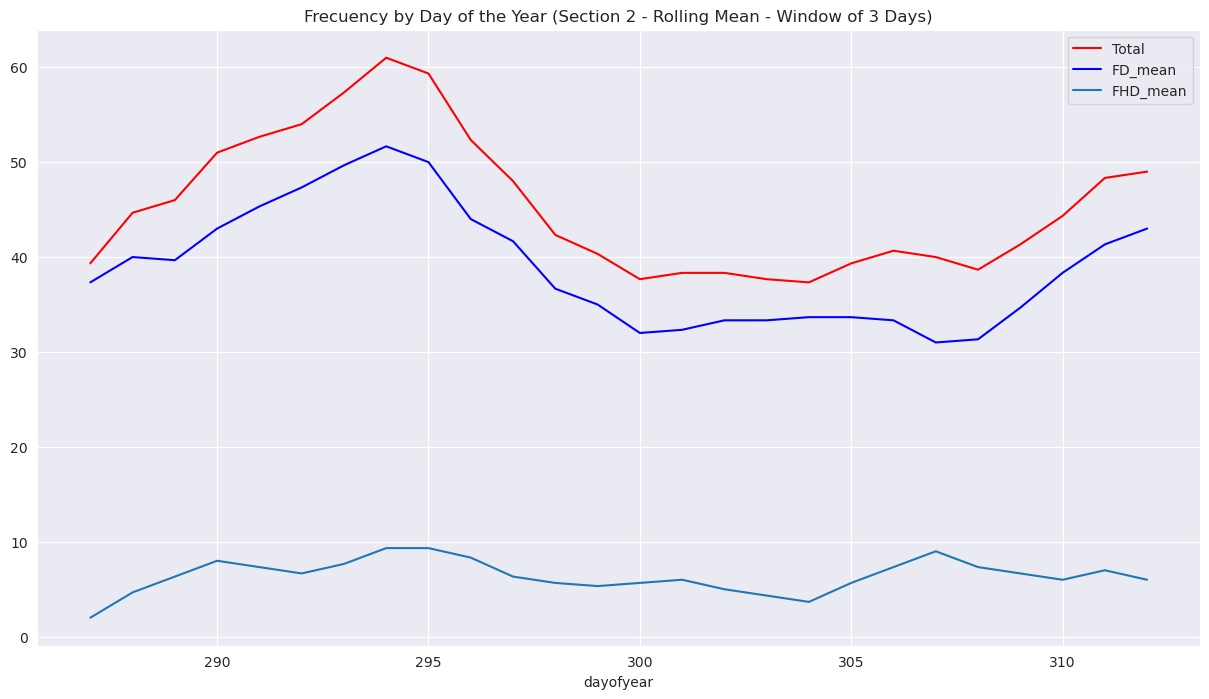

In [136]:
fig, ax = plt.subplots(figsize=(15,8))

data_sec_2_count["FD_FHD_mean"].plot(ax=ax, color="red", label="Total")
data_sec_2_count["FD_mean"].plot(ax=ax, color="blue")
data_sec_2_count["FHD_mean"].plot(ax=ax)

plt.title("Frecuency by Day of the Year (Section 2 - Rolling Mean - Window of 3 Days)")
plt.legend()
plt.show()


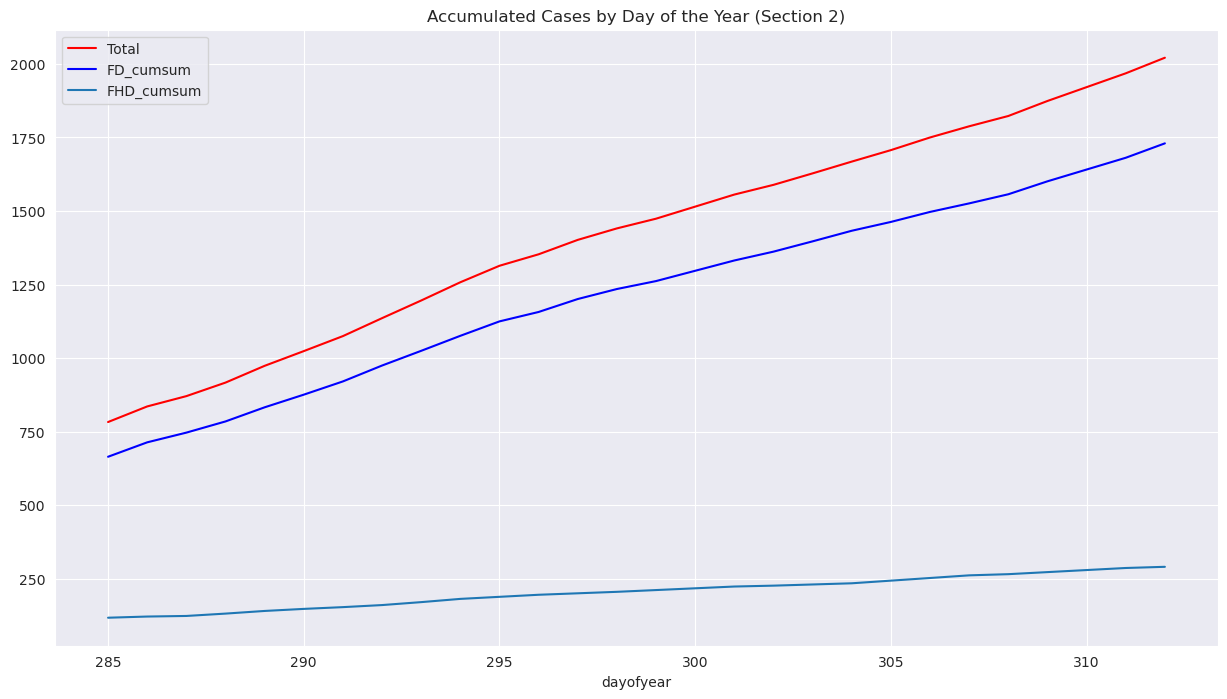

In [137]:
fig, ax = plt.subplots(figsize=(15,8))

data_sec_2_count["FD_FHD_cumsum"].plot(ax=ax, color="red", label="Total")
data_sec_2_count["FD_cumsum"].plot(ax=ax, color="blue")
data_sec_2_count["FHD_cumsum"].plot(ax=ax)
plt.title("Accumulated Cases by Day of the Year (Section 2)")
plt.legend()
plt.show()


In [138]:
kmeans_sec_2_df = data_sec_2[["x", "y", "SEXO", "EDAD", "GRADO_MA_1", "DENSI_POB", "week", "FD_FHD"]]
kmeans_sec_2_df.set_index(np.arange(len(kmeans_sec_2_df)), inplace=True)

sexo_df = pd.get_dummies(kmeans_sec_2_df["SEXO"], dtype="int", drop_first=True)
kmeans_sec_2_df = pd.concat([kmeans_sec_2_df, sexo_df], axis=1)
kmeans_sec_2_df.drop("SEXO", axis=1, inplace=True)

fd_fhd_df = pd.get_dummies(kmeans_sec_2_df["FD_FHD"], dtype="int", drop_first=True)
kmeans_sec_2_df = pd.concat([kmeans_sec_2_df, fd_fhd_df], axis=1)
kmeans_sec_2_df.drop("FD_FHD", axis=1, inplace=True)

kmeans_sec_2_df.columns = ["x", "y", "edad", "grad_marg", "densi_pob", "semana", "sexo", "FHD"]

kmeans_sec_2_df.head()

x          y  edad  grad_marg   densi_pob  semana  sexo  FHD
0 -111.033764  29.082121    18          1   23.603304      41     0    0
1 -110.983368  29.111957    12          2   62.181259      41     0    0
2 -110.994041  29.140176     8          3   96.244148      41     1    0
3 -110.952132  29.101309    42          1   23.850897      41     1    0
4 -110.983098  29.122470    45          1  111.530258      41     1    0

In [140]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
standard_scaled_df = pd.DataFrame(standard_scaler.fit_transform(kmeans_sec_2_df.drop(["sexo", "grad_marg", "semana", "FHD"], axis=1)))
min_max_scaled_df = pd.DataFrame(min_max_scaler.fit_transform(kmeans_sec_2_df[["grad_marg", "semana"]]))
standard_scaled_df.columns = ["x", "y", "edad", "densi_pob"]
min_max_scaled_df.columns = ["grad_marg", "semana"]

In [141]:
kmeans_sec_2_df = pd.concat([standard_scaled_df, min_max_scaled_df, kmeans_sec_2_df["sexo"]], axis=1)
kmeans_sec_2_df.head()

x         y      edad  densi_pob  grad_marg  semana  sexo
0 -2.397641 -0.905139 -0.796778  -1.687681       0.00     0.0     0
1 -0.202220  0.078572 -1.117444  -0.413390       0.25     0.0     0
2 -0.667193  1.008973 -1.331222   0.711761       0.50     0.0     1
3  1.158519 -0.272505  0.485889  -1.679502       0.00     0.0     1
4 -0.190453  0.425205  0.646223   1.216685       0.00     0.0     1

In [142]:
kmeans_sec_2_df.isna().sum()

x            0
y            0
edad         0
densi_pob    0
grad_marg    0
semana       0
sexo         0
dtype: int64

In [143]:
kmeans_sec_2 = KMeans(n_clusters=4).fit(kmeans_sec_2_df)
kmeans_sec_2.labels_

array([1, 3, 3, ..., 3, 1, 2], dtype=int32)

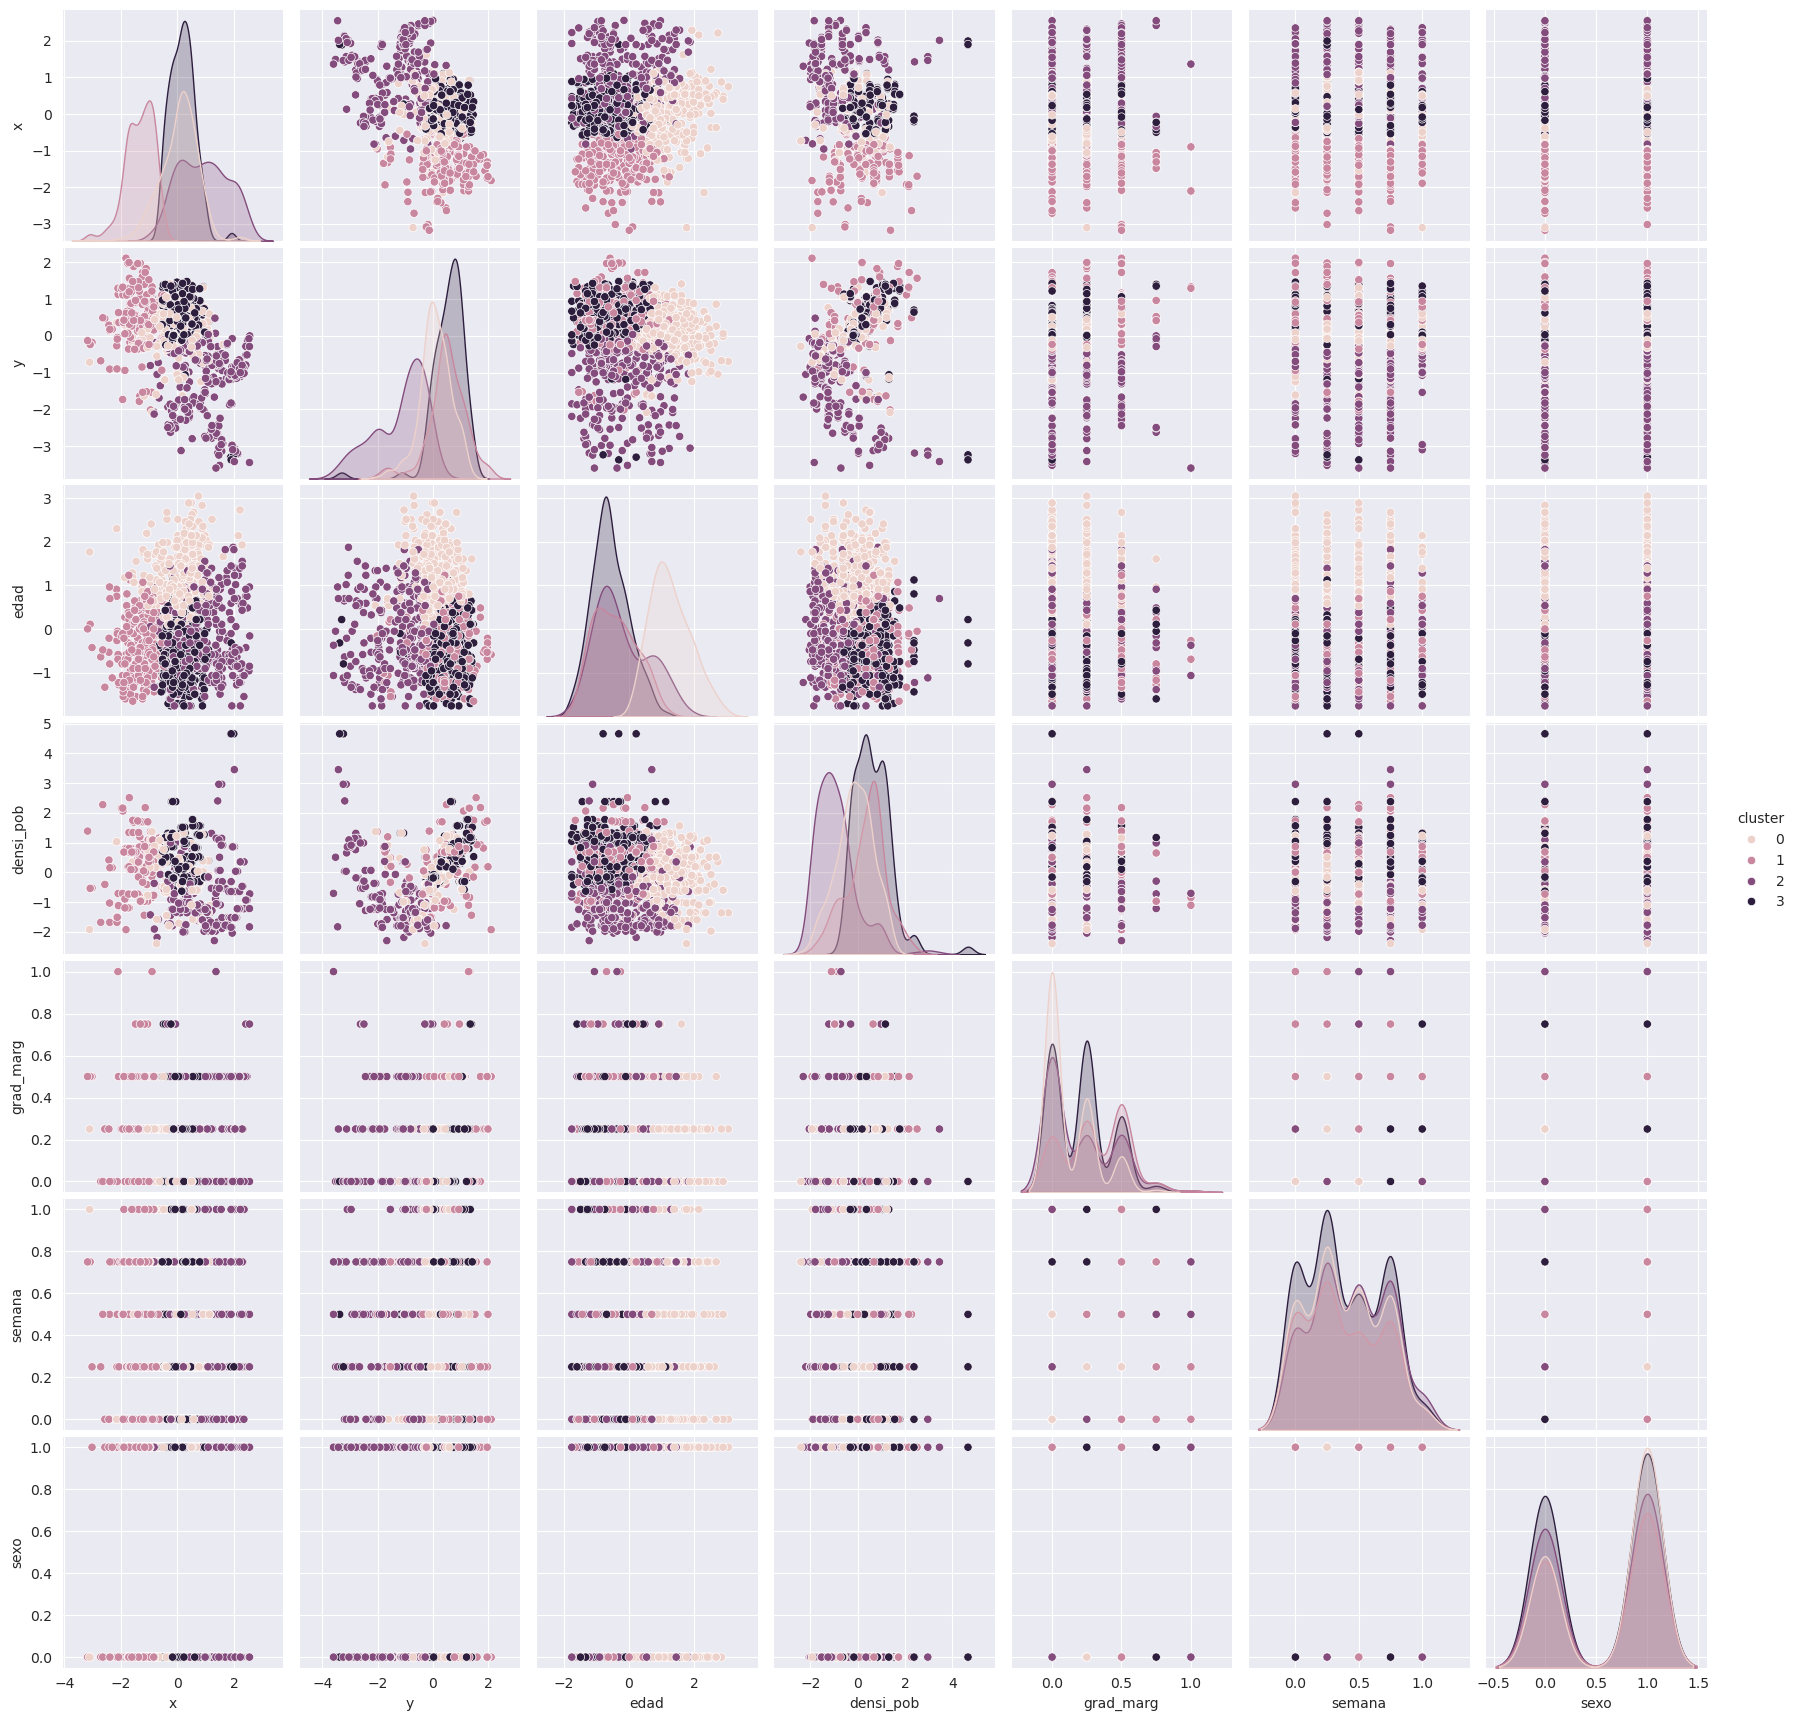

In [144]:
kmeans_sec_2_df["cluster"] = kmeans_sec_2.labels_
sns.pairplot(kmeans_sec_2_df, hue="cluster")

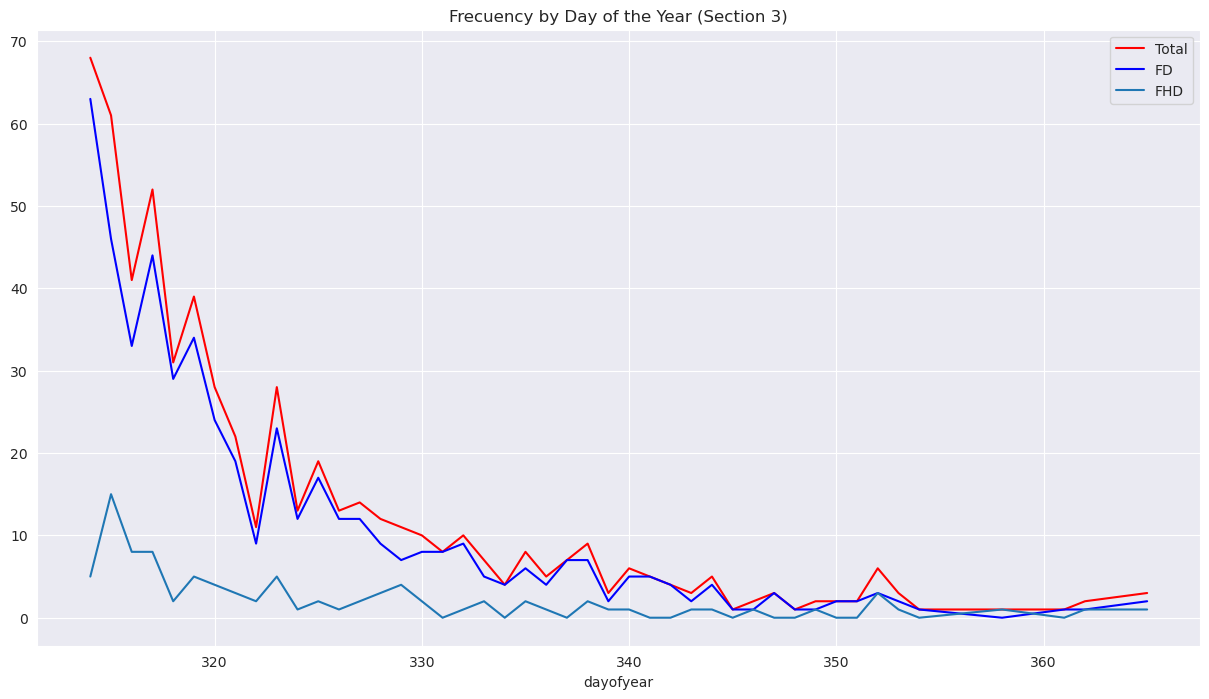

In [110]:
fig, ax = plt.subplots(figsize=(15,8))

data_sec_3_count["FD_FHD"].plot(ax=ax, color="red", label="Total")
data_sec_3_count["FD"].plot(ax=ax, color="blue")
data_sec_3_count["FHD"].plot(ax=ax)

plt.title("Frecuency by Day of the Year (Section 3)")
plt.legend()
plt.show()


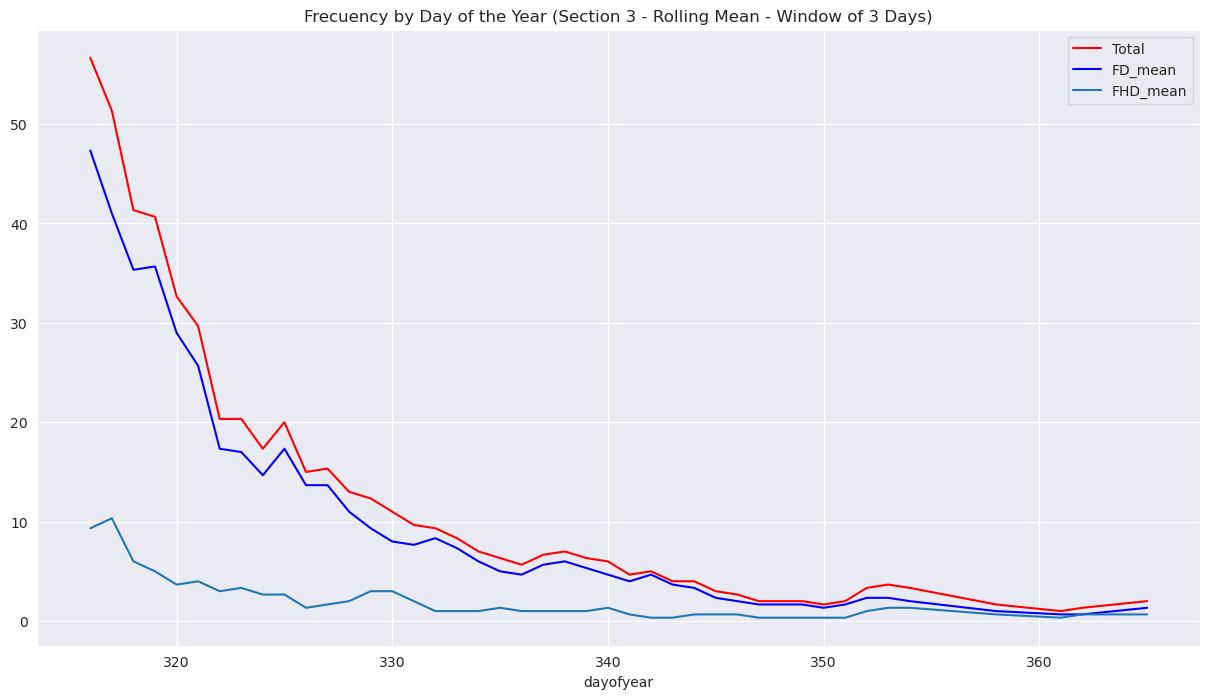

In [111]:
fig, ax = plt.subplots(figsize=(15,8))

data_sec_3_count["FD_FHD_mean"].plot(ax=ax, color="red", label="Total")
data_sec_3_count["FD_mean"].plot(ax=ax, color="blue")
data_sec_3_count["FHD_mean"].plot(ax=ax)

plt.title("Frecuency by Day of the Year (Section 3 - Rolling Mean - Window of 3 Days)")
plt.legend()
plt.show()


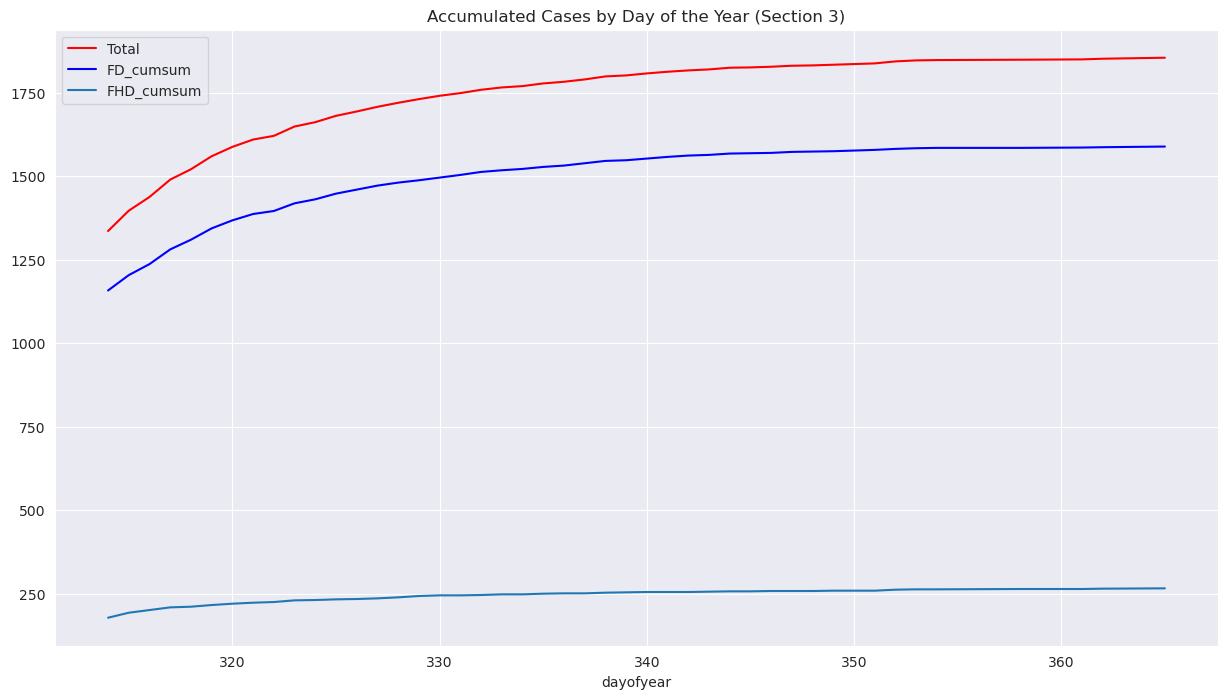

In [112]:
fig, ax = plt.subplots(figsize=(15,8))

data_sec_3_count["FD_FHD_cumsum"].plot(ax=ax, color="red", label="Total")
data_sec_3_count["FD_cumsum"].plot(ax=ax, color="blue")
data_sec_3_count["FHD_cumsum"].plot(ax=ax)
plt.title("Accumulated Cases by Day of the Year (Section 3)")
plt.legend()
plt.show()


In [145]:
kmeans_sec_3_df = data_sec_3[["x", "y", "SEXO", "EDAD", "GRADO_MA_1", "DENSI_POB", "week", "FD_FHD"]]
kmeans_sec_3_df.set_index(np.arange(len(kmeans_sec_3_df)), inplace=True)

sexo_df = pd.get_dummies(kmeans_sec_3_df["SEXO"], dtype="int", drop_first=True)
kmeans_sec_3_df = pd.concat([kmeans_sec_3_df, sexo_df], axis=1)
kmeans_sec_3_df.drop("SEXO", axis=1, inplace=True)

fd_fhd_df = pd.get_dummies(kmeans_sec_3_df["FD_FHD"], dtype="int", drop_first=True)
kmeans_sec_3_df = pd.concat([kmeans_sec_3_df, fd_fhd_df], axis=1)
kmeans_sec_3_df.drop("FD_FHD", axis=1, inplace=True)

kmeans_sec_3_df.columns = ["x", "y", "edad", "grad_marg", "densi_pob", "semana", "sexo", "FHD"]

kmeans_sec_3_df.head()

x          y  edad  grad_marg   densi_pob  semana  sexo  FHD
0 -110.927154  29.081739    20          3   55.012966      45     1    0
1 -110.992307  29.152592    20          4  110.073723      45     0    0
2 -110.966309  29.103291    32          1   62.636532      45     0    0
3 -110.953054  29.029038    14          1   68.954155      45     0    0
4 -111.042261  29.090876    42          2   16.374422      45     0    0

In [146]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
standard_scaled_df = pd.DataFrame(standard_scaler.fit_transform(kmeans_sec_3_df.drop(["sexo", "grad_marg", "semana", "FHD"], axis=1)))
min_max_scaled_df = pd.DataFrame(min_max_scaler.fit_transform(kmeans_sec_3_df[["grad_marg", "semana"]]))
standard_scaled_df.columns = ["x", "y", "edad", "densi_pob"]
min_max_scaled_df.columns = ["grad_marg", "semana"]

In [147]:
kmeans_sec_3_df = pd.concat([standard_scaled_df, min_max_scaled_df, kmeans_sec_3_df["sexo"]], axis=1)
kmeans_sec_3_df.head()

x         y      edad  densi_pob  grad_marg  semana  sexo
0  2.216068 -0.758663 -0.692293  -0.583537       0.50     0.0     1
1 -0.519133  1.369730 -0.692293   1.213584       0.75     0.0     0
2  0.572295 -0.111244 -0.008062  -0.334713       0.00     0.0     0
3  1.128733 -2.341767 -1.034408  -0.128512       0.00     0.0     0
4 -2.616263 -0.484208  0.562130  -1.844656       0.25     0.0     0

In [148]:
kmeans_sec_3_df.isna().sum()

x            0
y            0
edad         0
densi_pob    0
grad_marg    0
semana       0
sexo         0
dtype: int64

In [149]:
kmeans_sec_3 = KMeans(n_clusters=4).fit(kmeans_sec_3_df)
kmeans_sec_3.labels_

array([0, 2, 0, 0, 3, 2, 1, 0, 3, 0, 2, 3, 1, 0, 1, 3, 2, 3, 3, 1, 1, 3,
       3, 2, 0, 3, 3, 3, 3, 0, 2, 2, 2, 2, 3, 2, 3, 0, 0, 3, 0, 3, 1, 0,
       1, 0, 1, 3, 1, 0, 3, 3, 3, 1, 2, 2, 1, 0, 0, 0, 2, 1, 3, 0, 2, 2,
       0, 0, 1, 3, 1, 3, 1, 2, 1, 2, 0, 0, 2, 0, 3, 1, 2, 1, 2, 1, 2, 3,
       2, 2, 1, 0, 2, 3, 2, 1, 3, 1, 3, 1, 2, 1, 2, 2, 1, 2, 0, 1, 2, 2,
       3, 2, 2, 2, 1, 2, 2, 1, 2, 0, 0, 2, 2, 1, 1, 3, 1, 1, 3, 3, 0, 1,
       1, 2, 3, 3, 3, 2, 0, 3, 1, 0, 3, 3, 2, 2, 1, 0, 2, 2, 0, 1, 3, 2,
       3, 2, 3, 1, 3, 1, 2, 3, 1, 2, 2, 3, 1, 1, 1, 1, 0, 3, 0, 0, 0, 1,
       0, 3, 2, 0, 3, 0, 0, 3, 2, 3, 1, 3, 3, 3, 2, 3, 1, 2, 2, 0, 1, 2,
       2, 0, 1, 1, 3, 1, 1, 0, 3, 2, 0, 3, 2, 2, 2, 2, 1, 2, 2, 2, 1, 3,
       2, 1, 0, 3, 0, 1, 3, 0, 0, 0, 2, 2, 3, 1, 2, 1, 0, 2, 1, 0, 0, 0,
       0, 0, 3, 1, 3, 1, 0, 2, 2, 2, 3, 0, 2, 1, 1, 3, 0, 1, 2, 0, 3, 3,
       0, 2, 1, 2, 1, 3, 1, 3, 2, 1, 1, 1, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 3, 0, 1, 0, 1, 0, 0, 0, 1, 1,

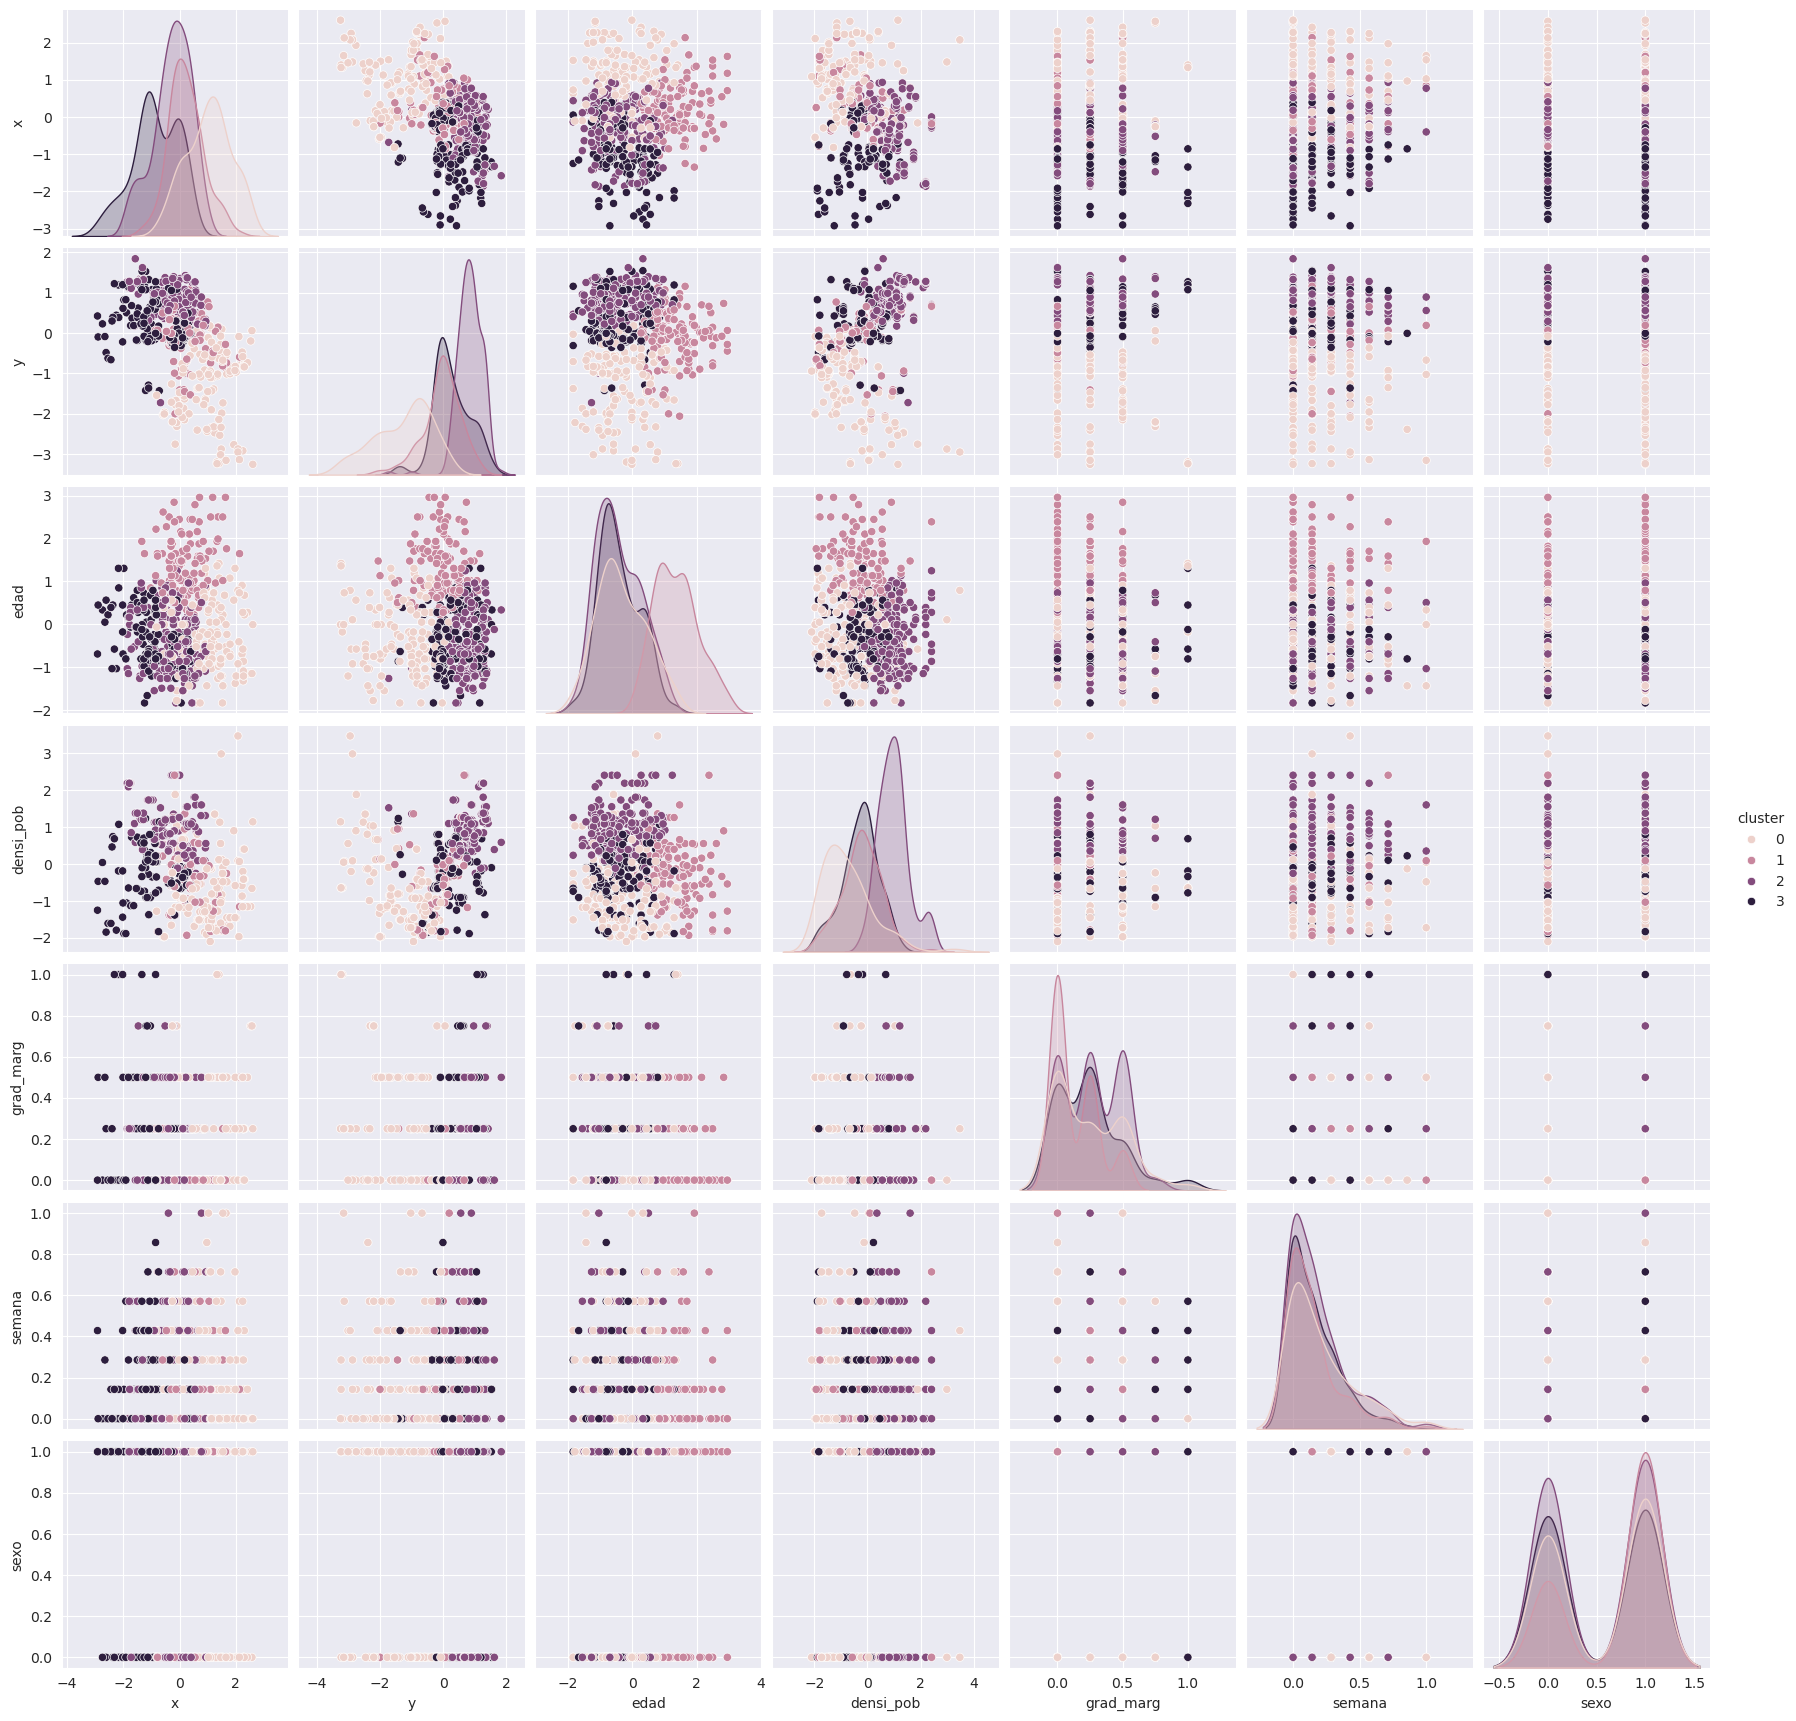

In [150]:
kmeans_sec_3_df["cluster"] = kmeans_sec_3.labels_
sns.pairplot(kmeans_sec_3_df, hue="cluster")

# Analysis by Week

In [72]:
# spike count by week

# Actual counts:
spike_count_by_week = pd.DataFrame(spike_data.groupby("week")["FD_FHD"].count())
spike_count_by_week["FD"] = spike_data.groupby("week")["FD"].sum()
spike_count_by_week["FHD"] = spike_data.groupby("week")["FHD"].sum()
# Cumulative total:
spike_count_by_week["FD_FHD_cumsum"] = spike_count_by_week["FD_FHD"].cumsum()
spike_count_by_week["FD_cumsum"] = spike_count_by_week["FD"].cumsum()
spike_count_by_week["FHD_cumsum"] = spike_count_by_week["FHD"].cumsum()
# Rolling mean:
spike_count_by_week["FD_FHD_mean"] = spike_count_by_week["FD_FHD"].rolling(3).mean()
spike_count_by_week["FD_mean"] = spike_count_by_week["FD"].rolling(3).mean()
spike_count_by_week["FHD_mean"] = spike_count_by_week["FHD"].rolling(3).mean()

spike_count_by_week.tail()

FD_FHD  FD  FHD  FD_FHD_cumsum  FD_cumsum  FHD_cumsum  FD_FHD_mean  \
week                                                                       
48        43  35    8           2653       2276         377    93.666667   
49        26  22    4           2679       2298         381    49.000000   
50        19  14    5           2698       2312         386    29.333333   
51         2   1    1           2700       2313         387    15.666667   
52         6   4    2           2706       2317         389     9.000000   

        FD_mean   FHD_mean  
week                        
48    79.333333  14.333333  
49    40.666667   8.333333  
50    23.666667   5.666667  
51    12.333333   3.333333  
52     6.333333   2.666667

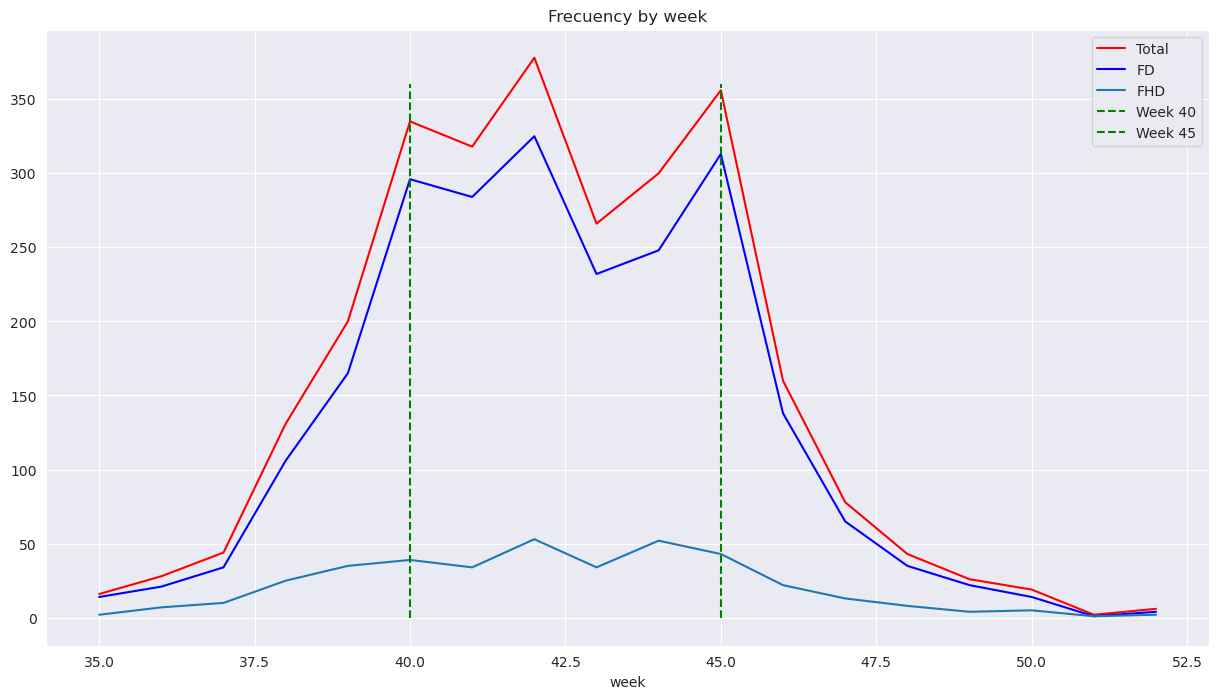

In [73]:
fig, ax = plt.subplots(figsize=(15,8))

spike_count_by_week["FD_FHD"].plot(ax=ax, color="red", label="Total")
spike_count_by_week["FD"].plot(ax=ax, color="blue")
spike_count_by_week["FHD"].plot(ax=ax)
division_1_week = 40
division_2_week = 45
plt.vlines(division_1_week, 0, 360, colors="green", linestyles='dashed', label=f"Week {division_1_week}")
plt.vlines(division_2_week, 0, 360, colors="green", linestyles='dashed', label=f"Week {division_2_week}")

plt.title("Frecuency by week")
plt.legend()
plt.show()

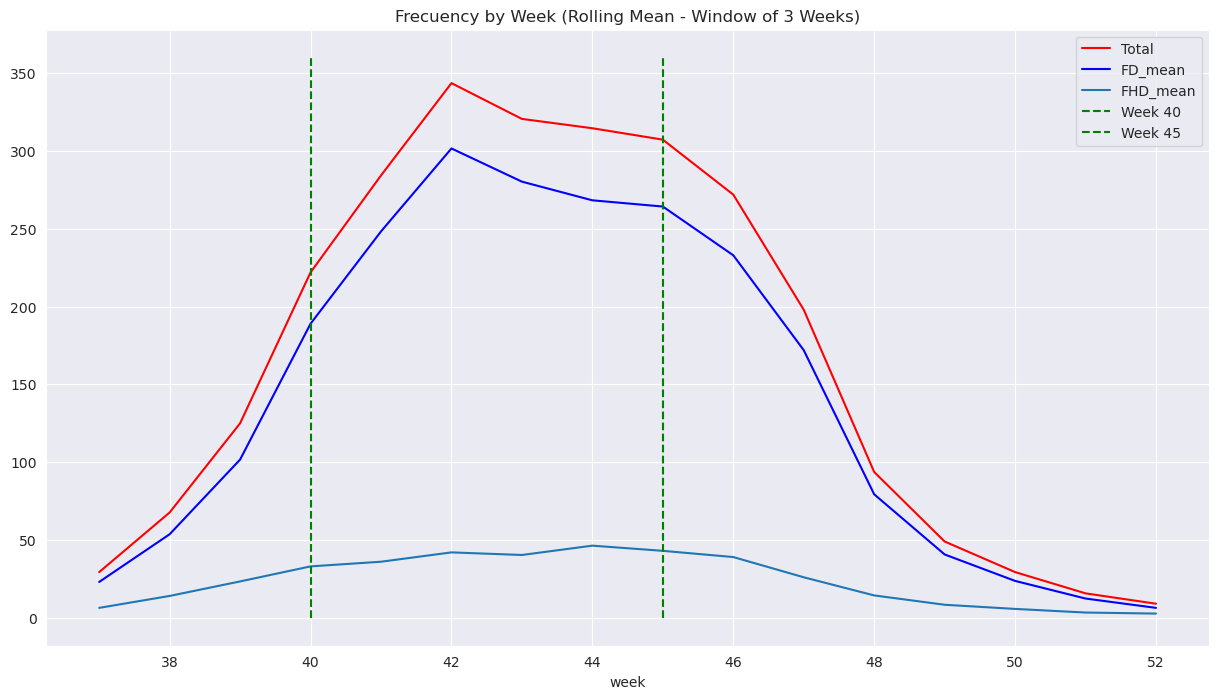

In [75]:
fig, ax = plt.subplots(figsize=(15,8))

spike_count_by_week["FD_FHD_mean"].plot(ax=ax, color="red", label="Total")
spike_count_by_week["FD_mean"].plot(ax=ax, color="blue")
spike_count_by_week["FHD_mean"].plot(ax=ax)
division_1_week = 40
division_2_week = 45
plt.vlines(division_1_week, 0, 360, colors="green", linestyles='dashed', label=f"Week {division_1_week}")
plt.vlines(division_2_week, 0, 360, colors="green", linestyles='dashed', label=f"Week {division_2_week}")

plt.title("Frecuency by Week (Rolling Mean - Window of 3 Weeks)")
plt.legend()
plt.show()

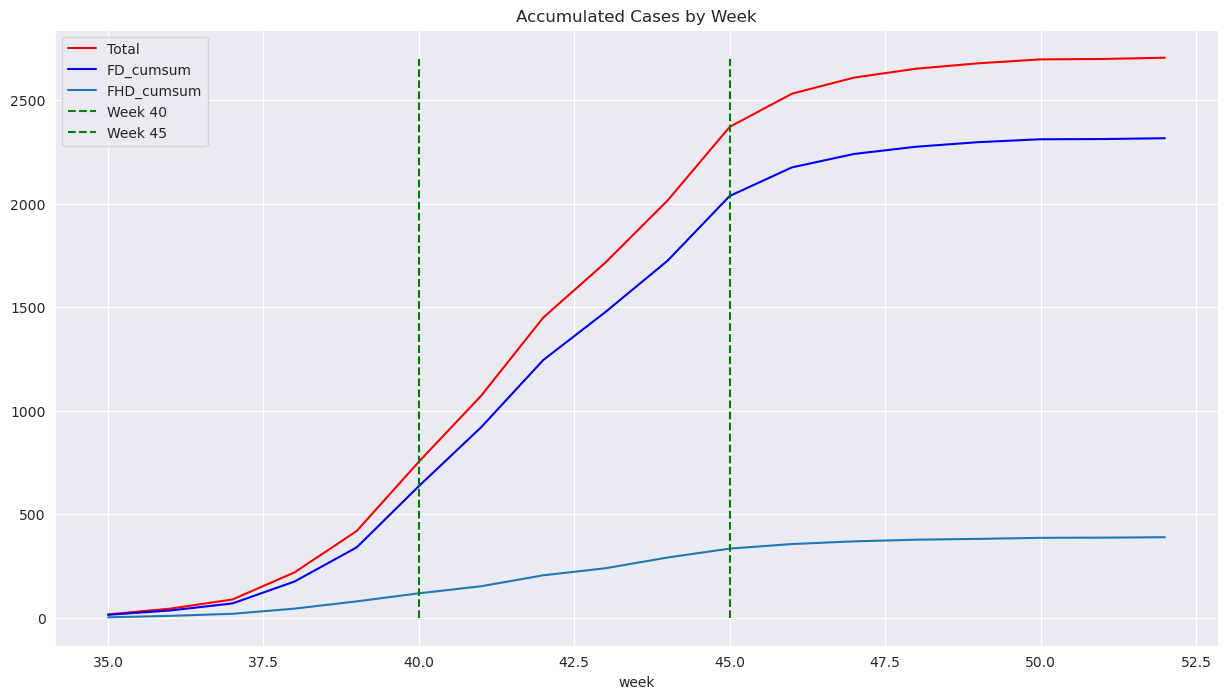

In [76]:
fig, ax = plt.subplots(figsize=(15,8))

spike_count_by_week["FD_FHD_cumsum"].plot(ax=ax, color="red", label="Total")
spike_count_by_week["FD_cumsum"].plot(ax=ax, color="blue")
spike_count_by_week["FHD_cumsum"].plot(ax=ax)
plt.vlines(division_1_week, 0, 2700, colors="green", linestyles='dashed', label=f"Week {division_1_week}")
plt.vlines(division_2_week, 0, 2700, colors="green", linestyles='dashed', label=f"Week {division_2_week}")

plt.title("Accumulated Cases by Week")
plt.legend()
plt.show()